# Import Libraries and Dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

import plotly.express as px
from plotly import graph_objs as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import xgboost as xgb

np.random.seed(0)

keys = ['A', 'D', 'S']
csv_files = [f for f in os.listdir() if f.split('.')[-1] in ['csv']]
csv_files

['asthma_dataset.csv', 'diabetes_data.csv', 'stroke_data.csv']

In [2]:
data_dict = dict()
for k, data in zip(keys, csv_files):
    data_dict[k] = pd.read_csv(data)

# Data Pre-processing

## Data Understanding

In [3]:
data_dict['A'].head()

,VAX_TYPE,AGE_YRS,SEX,SLEEPING_PROB,CHEST_TIGHTNESS,BREATH,COUGH,ALLERGY,WHEEZING,ASTHMA
0,HEPA,1.5,M,False,False,False,False,False,False,False
1,RV5,28.0,F,False,True,True,True,False,True,True
2,FLU3,53.0,F,False,False,False,False,False,False,False
3,HEP,69.0,M,False,False,False,False,False,False,False
4,HEPA,24.0,F,False,False,True,True,False,True,True


In [4]:
data_dict['D'].head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data_dict['S'].head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1


## Data Cleaning
Remove unnecessary variable - VAX_TYPE

In [6]:
data_dict['A'] = data_dict['A'].iloc[:,data_dict['A'].columns!="VAX_TYPE"]
data_dict['A'].head()

,AGE_YRS,SEX,SLEEPING_PROB,CHEST_TIGHTNESS,BREATH,COUGH,ALLERGY,WHEEZING,ASTHMA
0,1.5,M,False,False,False,False,False,False,False
1,28.0,F,False,True,True,True,False,True,True
2,53.0,F,False,False,False,False,False,False,False
3,69.0,M,False,False,False,False,False,False,False
4,24.0,F,False,False,True,True,False,True,True


## Find all unique value for each class

In [7]:
# To identify the unique values of each column
def show_unique_values(df: pd.DataFrame): 
    data = []
    for col in df.columns:
        unique_value = np.unique(df[col]).tolist()
        temp_str = ""
        data.append([col, len(unique_value), ", ".join(str(value) for value in unique_value)])
    df_temp = pd.DataFrame(data, columns=["Columns Name", "Num of unique value", "Unique Value"])
    pd.options.display.max_colwidth = 50
    return df_temp   

def check_null(data: pd.DataFrame, solver: str=None):
    if solver not in ['remove', 'replace', None]:
        raise ValueError(f"The argument only takes 'remove' or 'replace' but found '{solver}'.")
    
    contain_null = data.isnull().any().any()
    if not contain_null: 
        print("The dataset does not contain any null values.")
        return 
    
    col_miss = [(col,data[col].isnull().sum()) for col in data.columns if data[col].isnull().sum() > 0]
    print("Columns with missing values and the number of missing value: ", col_miss)
    if not solver:
        pass
    elif solver == 'remove':
        return data.dropna()
    elif solver == 'replace':
        for col,_ in col_miss:
            mean = data[col].mean()     
            data.loc[:,col].fillna(mean, inplace=True)
        return data
    
    

In [8]:
show_unique_values(data_dict['A'])

,Columns Name,Num of unique value,Unique Value
0,AGE_YRS,344,"0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,..."
1,SEX,3,"F, M, U"
2,SLEEPING_PROB,2,"False, True"
3,CHEST_TIGHTNESS,2,"False, True"
4,BREATH,2,"False, True"
5,COUGH,2,"False, True"
6,ALLERGY,2,"False, True"
7,WHEEZING,2,"False, True"
8,ASTHMA,2,"False, True"


In [9]:
show_unique_values(data_dict['A'].dropna())

,Columns Name,Num of unique value,Unique Value
0,AGE_YRS,343,"0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,..."
1,SEX,3,"F, M, U"
2,SLEEPING_PROB,2,"False, True"
3,CHEST_TIGHTNESS,2,"False, True"
4,BREATH,2,"False, True"
5,COUGH,2,"False, True"
6,ALLERGY,2,"False, True"
7,WHEEZING,2,"False, True"
8,ASTHMA,2,"False, True"


In [10]:
data_dict['A'] = data_dict['A'].drop(data_dict['A'][data_dict['A']['SEX'] == 'U'].index)
show_unique_values(data_dict['A'].dropna())

,Columns Name,Num of unique value,Unique Value
0,AGE_YRS,335,"0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,..."
1,SEX,2,"F, M"
2,SLEEPING_PROB,2,"False, True"
3,CHEST_TIGHTNESS,2,"False, True"
4,BREATH,2,"False, True"
5,COUGH,2,"False, True"
6,ALLERGY,2,"False, True"
7,WHEEZING,2,"False, True"
8,ASTHMA,2,"False, True"


In [11]:
show_unique_values(data_dict['D'])

,Columns Name,Num of unique value,Unique Value
0,Age,13,"1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 1..."
1,Sex,2,"0.0, 1.0"
2,HighChol,2,"0.0, 1.0"
3,CholCheck,2,"0.0, 1.0"
4,BMI,80,"12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0..."
5,Smoker,2,"0.0, 1.0"
6,HeartDiseaseorAttack,2,"0.0, 1.0"
7,PhysActivity,2,"0.0, 1.0"
8,Fruits,2,"0.0, 1.0"
9,Veggies,2,"0.0, 1.0"


In [12]:
show_unique_values(data_dict['D'].dropna())

,Columns Name,Num of unique value,Unique Value
0,Age,13,"1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 1..."
1,Sex,2,"0.0, 1.0"
2,HighChol,2,"0.0, 1.0"
3,CholCheck,2,"0.0, 1.0"
4,BMI,80,"12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0..."
5,Smoker,2,"0.0, 1.0"
6,HeartDiseaseorAttack,2,"0.0, 1.0"
7,PhysActivity,2,"0.0, 1.0"
8,Fruits,2,"0.0, 1.0"
9,Veggies,2,"0.0, 1.0"


In [28]:
show_unique_values(data_dict['S'].dropna())

,Columns Name,Num of unique value,Unique Value
0,sex,2,"0.0, 1.0"
1,age,104,"0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9..."
2,hypertension,2,"0, 1"
3,heart_disease,2,"0, 1"
4,ever_married,2,"0, 1"
5,work_type,5,"0, 1, 2, 3, 4"
6,Residence_type,2,"0, 1"
7,avg_glucose_level,2903,"55.12, 55.22, 55.25, 55.27, 55.32, 55.34, 55.4..."
8,bmi,370,"11.5, 14.1, 15.0, 15.3, 15.4, 15.7, 16.0, 16.1..."
9,smoking_status,2,"0, 1"


In [ ]:
data_dict['S'] = data_dict['S'][data_dict['S']['age'] >= 0]

negative_val = data_dict['S']['age'][data_dict['S']['age'] < 0]
len(negative_val)

In [25]:
data_dict['A'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 251676 entries, 0 to 309225
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AGE_YRS          235396 non-null  float64
 1   SEX              251676 non-null  object 
 2   SLEEPING_PROB    251676 non-null  bool   
 3   CHEST_TIGHTNESS  251676 non-null  bool   
 4   BREATH           251676 non-null  bool   
 5   COUGH            251676 non-null  bool   
 6   ALLERGY          251676 non-null  bool   
 7   WHEEZING         251676 non-null  bool   
 8   ASTHMA           251676 non-null  bool   
dtypes: bool(7), float64(1), object(1)
memory usage: 7.4+ MB


In [26]:
data_dict['D'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke             

In [27]:
data_dict['S'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 40852 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40849 non-null  float64
 1   age                40852 non-null  float64
 2   hypertension       40852 non-null  int64  
 3   heart_disease      40852 non-null  int64  
 4   ever_married       40852 non-null  int64  
 5   work_type          40852 non-null  int64  
 6   Residence_type     40852 non-null  int64  
 7   avg_glucose_level  40852 non-null  float64
 8   bmi                40852 non-null  float64
 9   smoking_status     40852 non-null  int64  
 10  stroke             40852 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.7 MB


In [29]:
col_miss_asthma = [(col,data_dict['A'][col].isna().sum()) for col in data_dict['A'].columns if data_dict['A'][col].isna().sum() > 0]
col_miss_asthma

[('AGE_YRS', 16280)]

In [30]:
data_dict['A'].dropna(subset=[col for col, _ in col_miss_asthma], inplace=True)

In [31]:
col_miss_diabetes = [(col,data_dict['D'][col].isna().sum()) for col in data_dict['D'].columns if data_dict['D'][col].isna().sum() > 0]
col_miss_diabetes

[]

In [32]:
col_miss_stroke = [(col,data_dict['S'][col].isna().sum()) for col in data_dict['S'].columns if data_dict['S'][col].isna().sum() > 0]
col_miss_stroke

[('sex', 3)]

In [33]:
data_dict['S'].dropna(subset=[col for col, _ in col_miss_stroke], inplace=True)

In [34]:
data_dict['A']['ASTHMA'].value_counts()

ASTHMA
False    219417
True      15979
Name: count, dtype: int64

In [35]:
data_dict['D']['Diabetes'].value_counts()

Diabetes
0.0    35346
1.0    35346
Name: count, dtype: int64

In [36]:
data_dict['S']['stroke'].value_counts()

stroke
0    20447
1    20402
Name: count, dtype: int64

## Get the categorical and numerical columns name

In [37]:
numerical_a = [x for x in data_dict['A'].columns if len(data_dict['A'][x].unique()) > 6]    # define categorical variables (columns)
categorical_a = list(set(data_dict['A'].columns) - set(numerical_a))  # define numerical variables (columns)

print(f"{len(numerical_a)} Numerical variables (columns) are: {np.sort(numerical_a)}\n")
print(f"{len(categorical_a)} Categorical variables (columns) are: {np.sort(categorical_a)}")

1 Numerical variables (columns) are: ['AGE_YRS']

8 Categorical variables (columns) are: ['ALLERGY' 'ASTHMA' 'BREATH' 'CHEST_TIGHTNESS' 'COUGH' 'SEX'
 'SLEEPING_PROB' 'WHEEZING']


In [38]:
numerical_d = [x for x in data_dict['D'].columns if len(data_dict['D'][x].unique()) > 13]    # define categorical variables (columns)
categorical_d = list(set(data_dict['D'].columns) - set(numerical_d))  # define numerical variables (columns)

print(f"{len(numerical_d)} Numerical variables (columns) are: {np.sort(numerical_d)}\n")
print(f"{len(categorical_d)} Categorical variables (columns) are: {np.sort(categorical_d)}")

3 Numerical variables (columns) are: ['BMI' 'MentHlth' 'PhysHlth']

15 Categorical variables (columns) are: ['Age' 'CholCheck' 'Diabetes' 'DiffWalk' 'Fruits' 'GenHlth'
 'HeartDiseaseorAttack' 'HighBP' 'HighChol' 'HvyAlcoholConsump'
 'PhysActivity' 'Sex' 'Smoker' 'Stroke' 'Veggies']


In [39]:
numerical_s = [x for x in data_dict['S'].columns if len(data_dict['S'][x].unique()) > 6]    # define categorical variables (columns)
categorical_s = list(set(data_dict['S'].columns) - set(numerical_s))  # define numerical variables (columns)

print(f"{len(numerical_s)} Numerical variables (columns) are: {np.sort(numerical_s)}\n")
print(f"{len(categorical_s)} Categorical variables (columns) are: {np.sort(categorical_s)}")

3 Numerical variables (columns) are: ['age' 'avg_glucose_level' 'bmi']

8 Categorical variables (columns) are: ['Residence_type' 'ever_married' 'heart_disease' 'hypertension' 'sex'
 'smoking_status' 'stroke' 'work_type']


# Exploratory Data Analysis (EDA)

## Boxplot for numerical variable

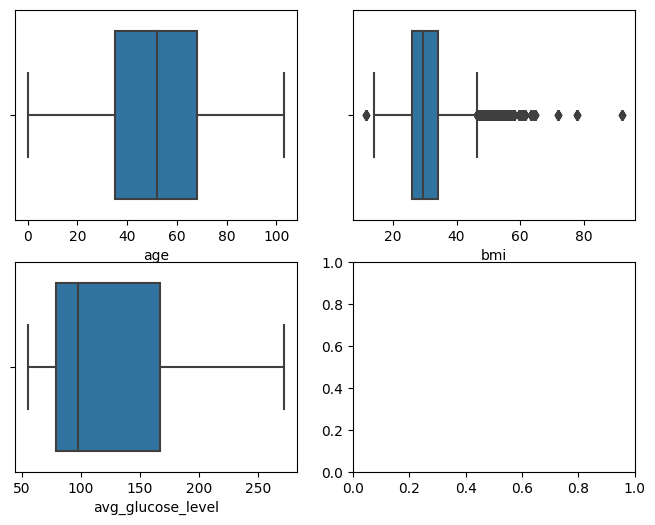

In [40]:
_, ax = plt.subplots(2, 2, figsize=(8, 6))

for i, feature in enumerate(numerical_s):
    sns.boxplot(data=data_dict['S'], x=feature, ax = ax[i%2, i//2])

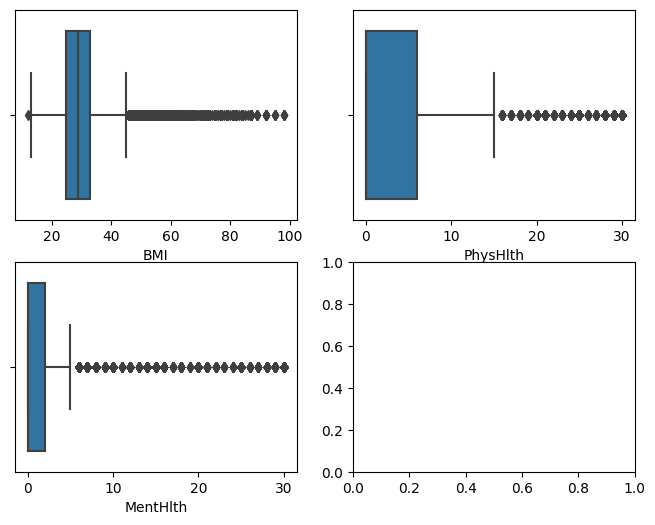

In [41]:
_, ax = plt.subplots(2, 2, figsize=(8, 6))

for i, feature in enumerate(numerical_d):
    sns.boxplot(data=data_dict['D'], x=feature, ax = ax[i%2, i//2])

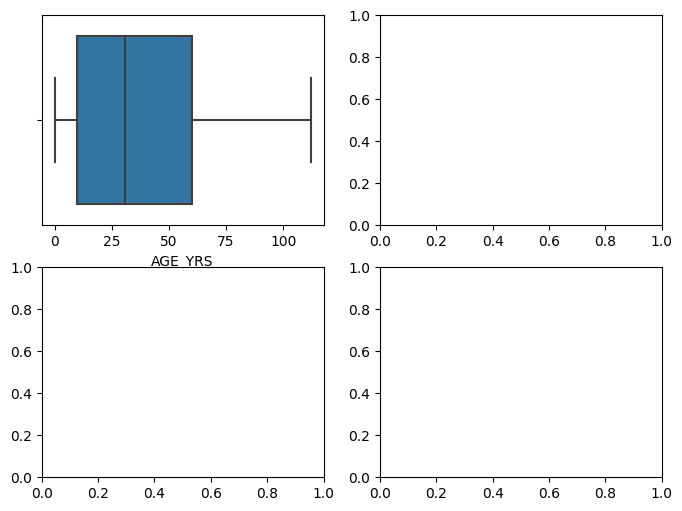

In [42]:
_, ax = plt.subplots(2, 2, figsize=(8, 6))

for i, feature in enumerate(numerical_a):
    sns.boxplot(data=data_dict['A'], x=feature, ax = ax[i%2, i//2])

## Kernel Density Estimate for numerical variable

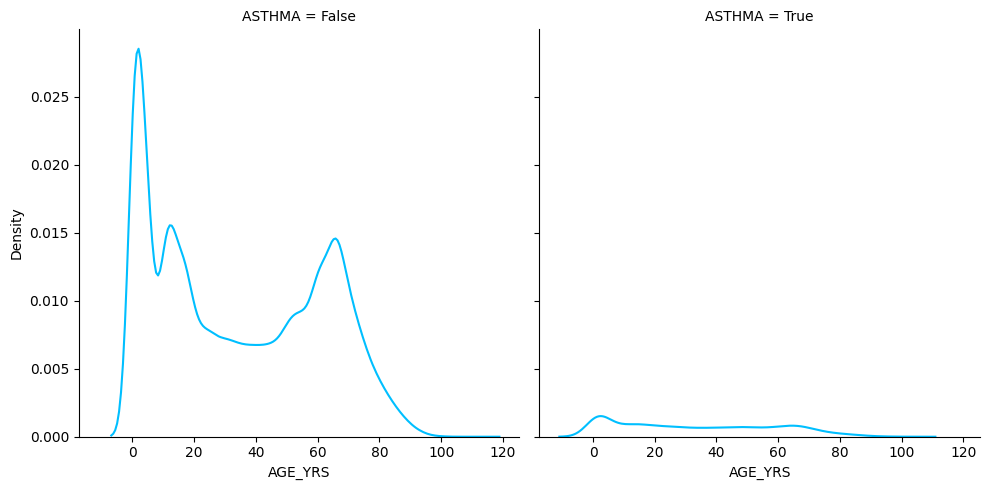

In [43]:
for feature in numerical_a: # KDE distribution of numerical feature
    sns.displot(x = feature,col='ASTHMA',data = data_dict['A'], kind="kde" ,color = 'deepskyblue')

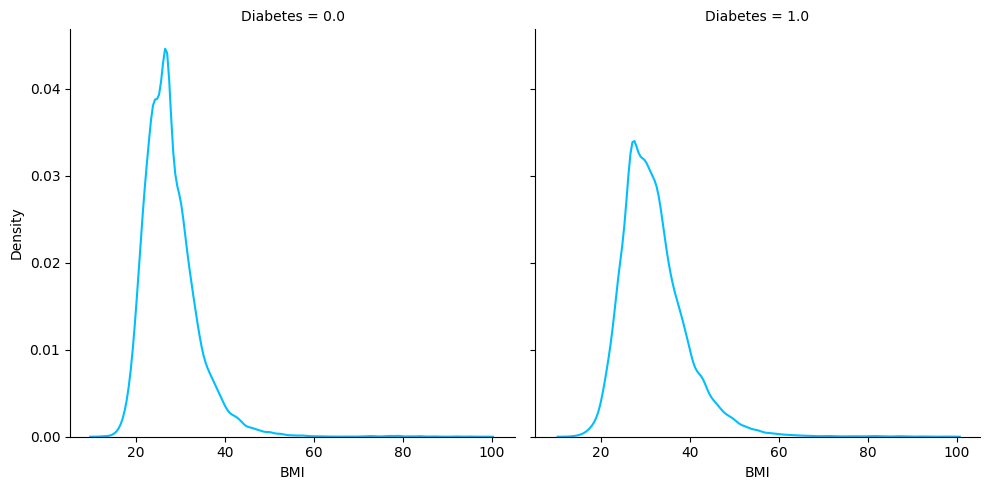

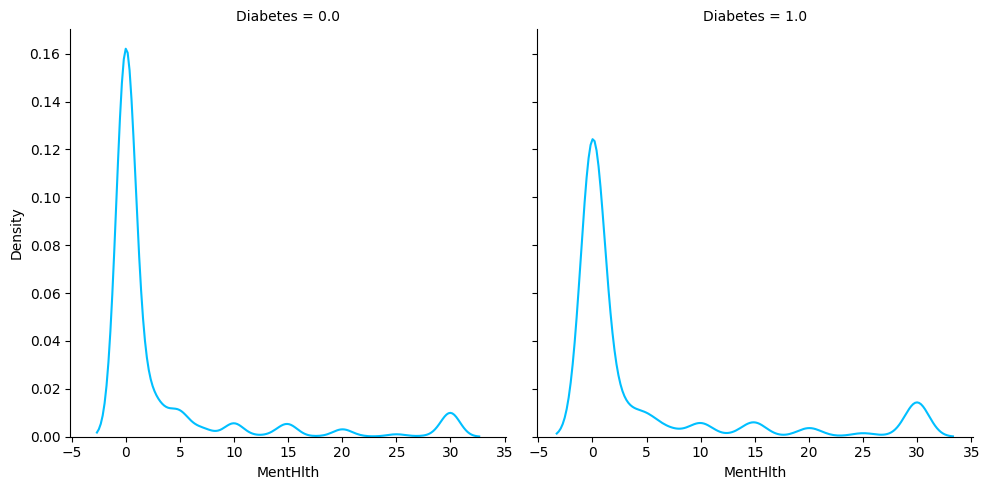

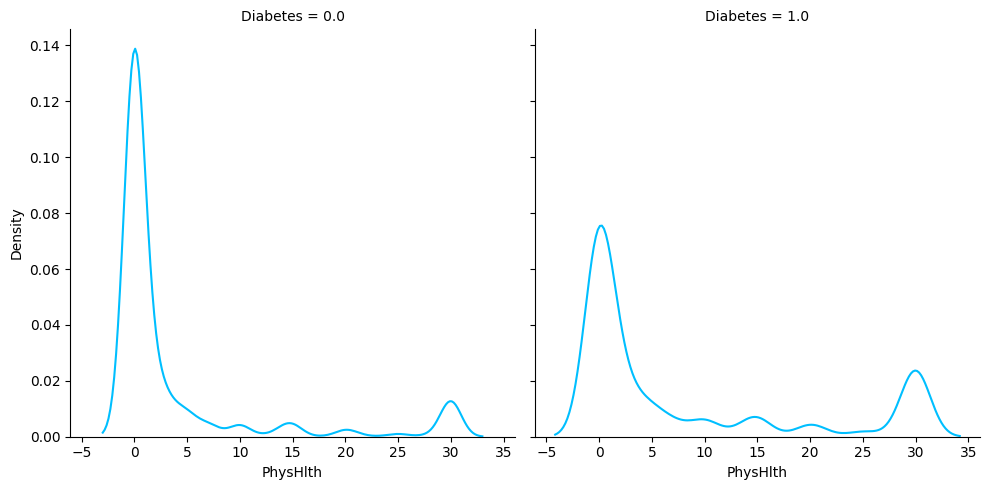

In [32]:
for feature in numerical_d: # KDE distribution of numerical feature
    sns.displot(x = feature,col='Diabetes',data = data_dict['D'], kind="kde" ,color = 'deepskyblue')

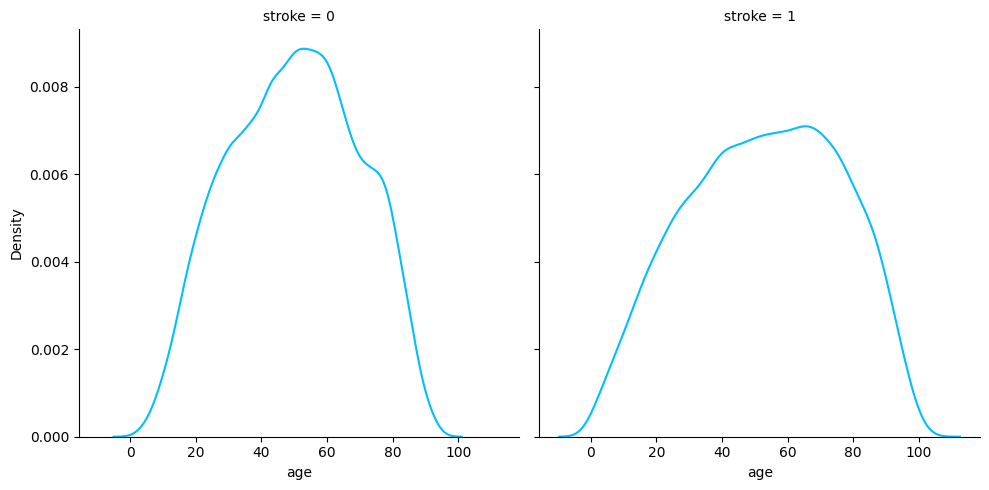

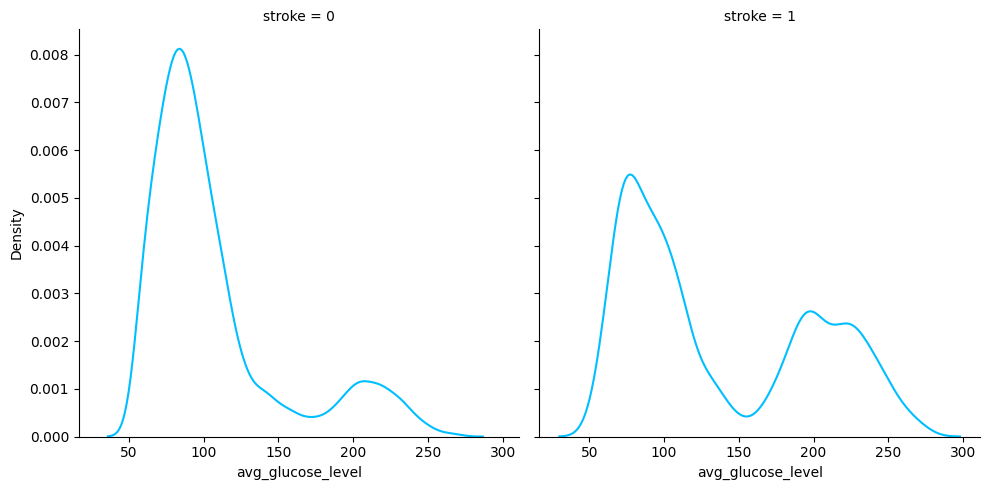

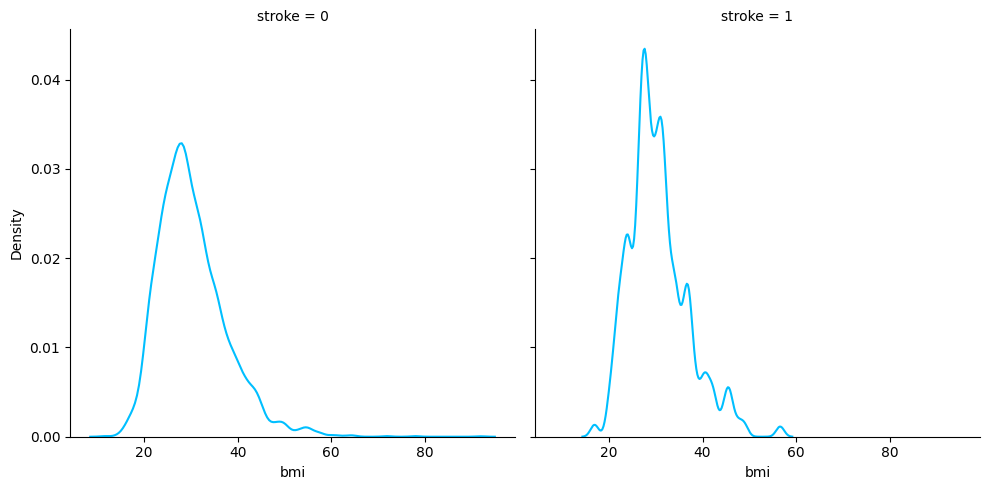

In [44]:
for feature in numerical_s: # KDE distribution of numerical feature
    sns.displot(x = feature,col='stroke',data = data_dict['S'], kind="kde" ,color = 'deepskyblue')

In [45]:
"""Calculating the skewness of the numerical columns to show evidence of the assumption we made"""
df_skew = pd.DataFrame(data_dict['A'][numerical_a].skew())
df_skew.columns = ['skewness']

# |skew| > 0.50 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.50 
df_skew

,skewness,too_skewed
AGE_YRS,0.233546,False


In [46]:
"""Calculating the skewness of the numerical columns to show evidence of the assumption we made"""
df_skew = pd.DataFrame(data_dict['D'][numerical_d].skew())
df_skew.columns = ['skewness']

# |skew| > 0.50 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.50 
df_skew

,skewness,too_skewed
BMI,1.719180,True
MentHlth,2.388110,True
PhysHlth,1.657304,True


In [47]:
"""Calculating the skewness of the numerical columns to show evidence of the assumption we made"""
df_skew = pd.DataFrame(data_dict['S'][numerical_s].skew())
df_skew.columns = ['skewness']

# |skew| > 0.50 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.50 
df_skew

,skewness,too_skewed
age,-0.067865,False
avg_glucose_level,0.945126,True
bmi,1.077175,True


## Histogram and Bivariate bar plot for categorical variables

In [48]:
def bivariate_bar_plot_for_a(n_cols, columns, figsize=(12,8)):
    n_rows = int(np.ceil(len(columns) / n_cols))
    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = figsize)
    plt.suptitle('Asthma by categorical features')

    for i, col in enumerate(columns):
        x = sns.countplot(data=data_dict['A'][categorical_a], x=col, hue='ASTHMA', palette = ['deepskyblue','crimson'], ax=ax[i//n_cols, i%n_cols])
        for z in x.patches:
          x.annotate('{:.1f}'.format((z.get_height()/data_dict['A'][categorical_a].shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

In [49]:
n_cols = 3
n_rows = n_rows = int(np.ceil(len(categorical_a.copy()) / n_cols))

"""Histogram using plotly"""
fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=tuple(categorical_a.copy()))

for i, col in enumerate(categorical_a.copy()):
    counts = data_dict['A'][col].value_counts()
    fig.add_trace(go.Bar(name=col, x=counts.index, y=counts.values), 
                  row=i//n_cols + 1,
                  col=i%n_cols + 1)

fig.update_layout(title="Histogram plot of categorical columns",
                 height=600,
                 width=800,
                 showlegend=False)

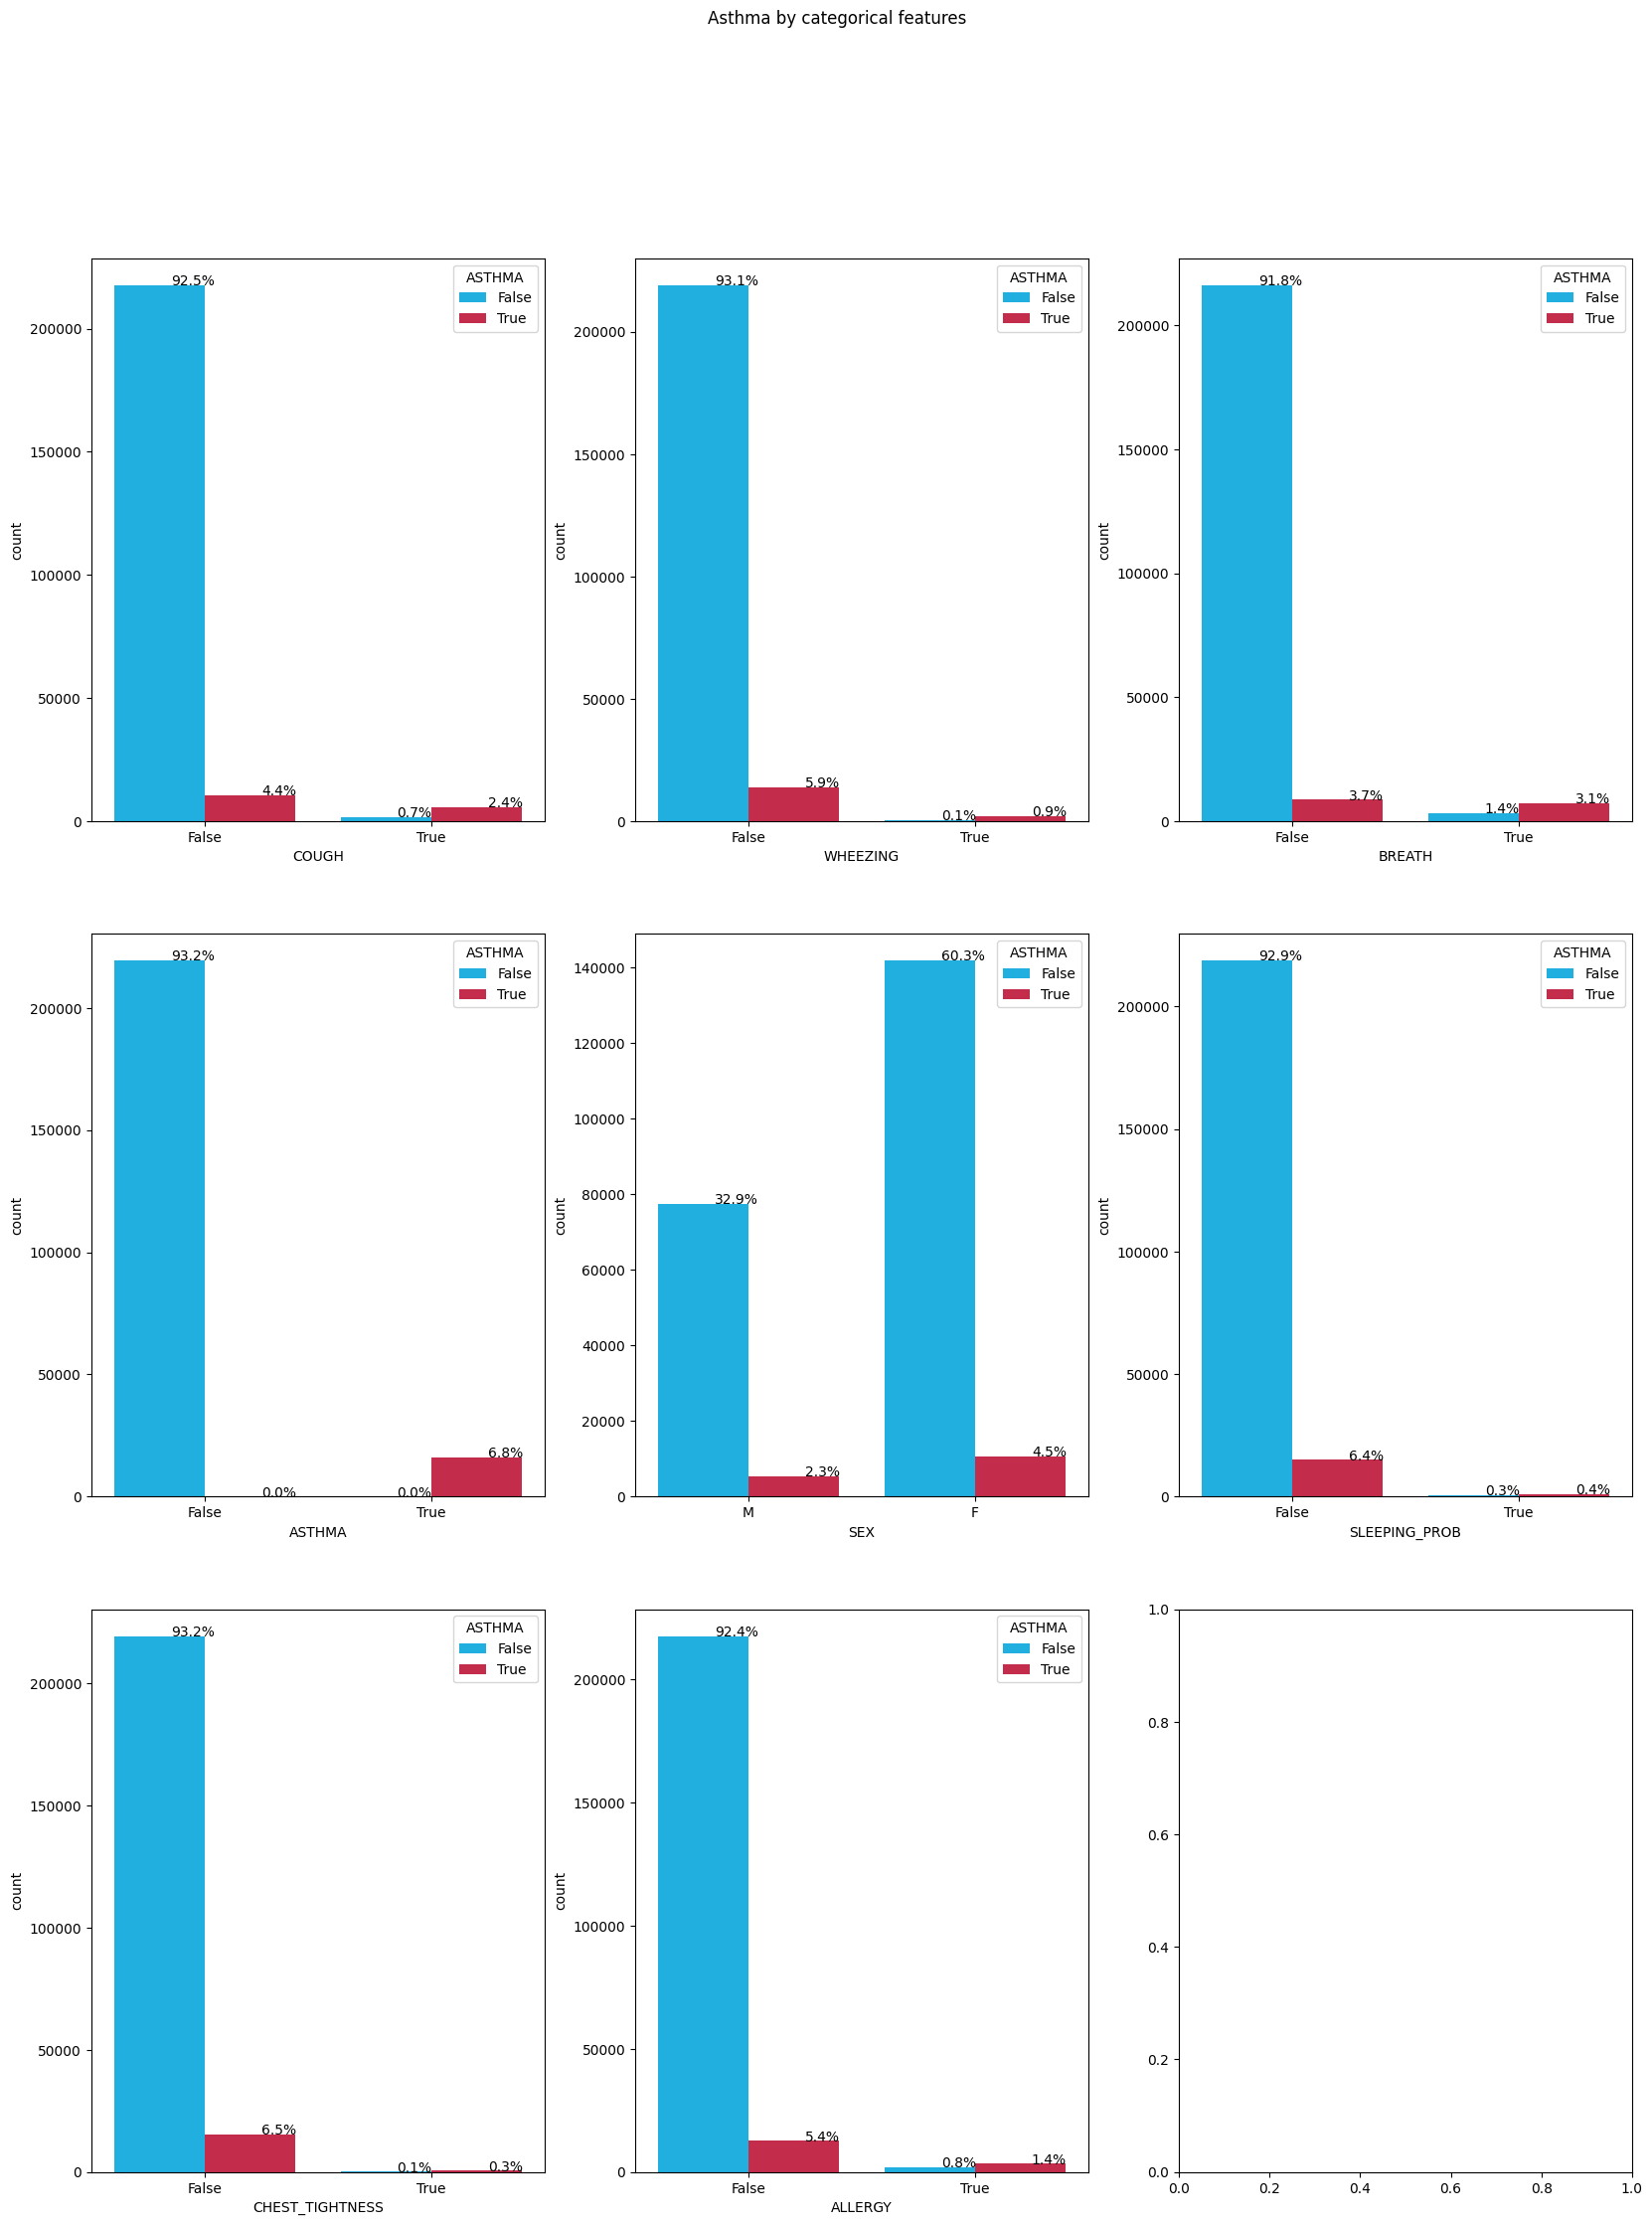

In [50]:
bivariate_bar_plot_for_a(3, categorical_a.copy(), (20,25))

In [51]:
def bivariate_bar_plot_for_d(n_cols, columns, figsize=(12,8)):
    n_rows = int(np.ceil(len(columns) / n_cols))
    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = figsize)
    plt.suptitle('Diabetes by categorical features')

    for i, col in enumerate(columns):
        x = sns.countplot(data=data_dict['D'][categorical_d], x=col, hue='Diabetes', palette = ['deepskyblue','crimson'], ax=ax[i//n_cols, i%n_cols])
        for z in x.patches:
          x.annotate('{:.1f}'.format((z.get_height()/data_dict['D'][categorical_d].shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

In [52]:
n_cols = 3
n_rows = n_rows = int(np.ceil(len(categorical_d.copy()) / n_cols))

"""Histogram using plotly"""
fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=tuple(categorical_d.copy()))

for i, col in enumerate(categorical_d.copy()):
    counts = data_dict['D'][col].value_counts()
    fig.add_trace(go.Bar(name=col, x=counts.index, y=counts.values), 
                  row=i//n_cols + 1,
                  col=i%n_cols + 1)

fig.update_layout(title="Histogram plot of categorical columns",
                 height=800,
                 width=1000,
                 showlegend=False)

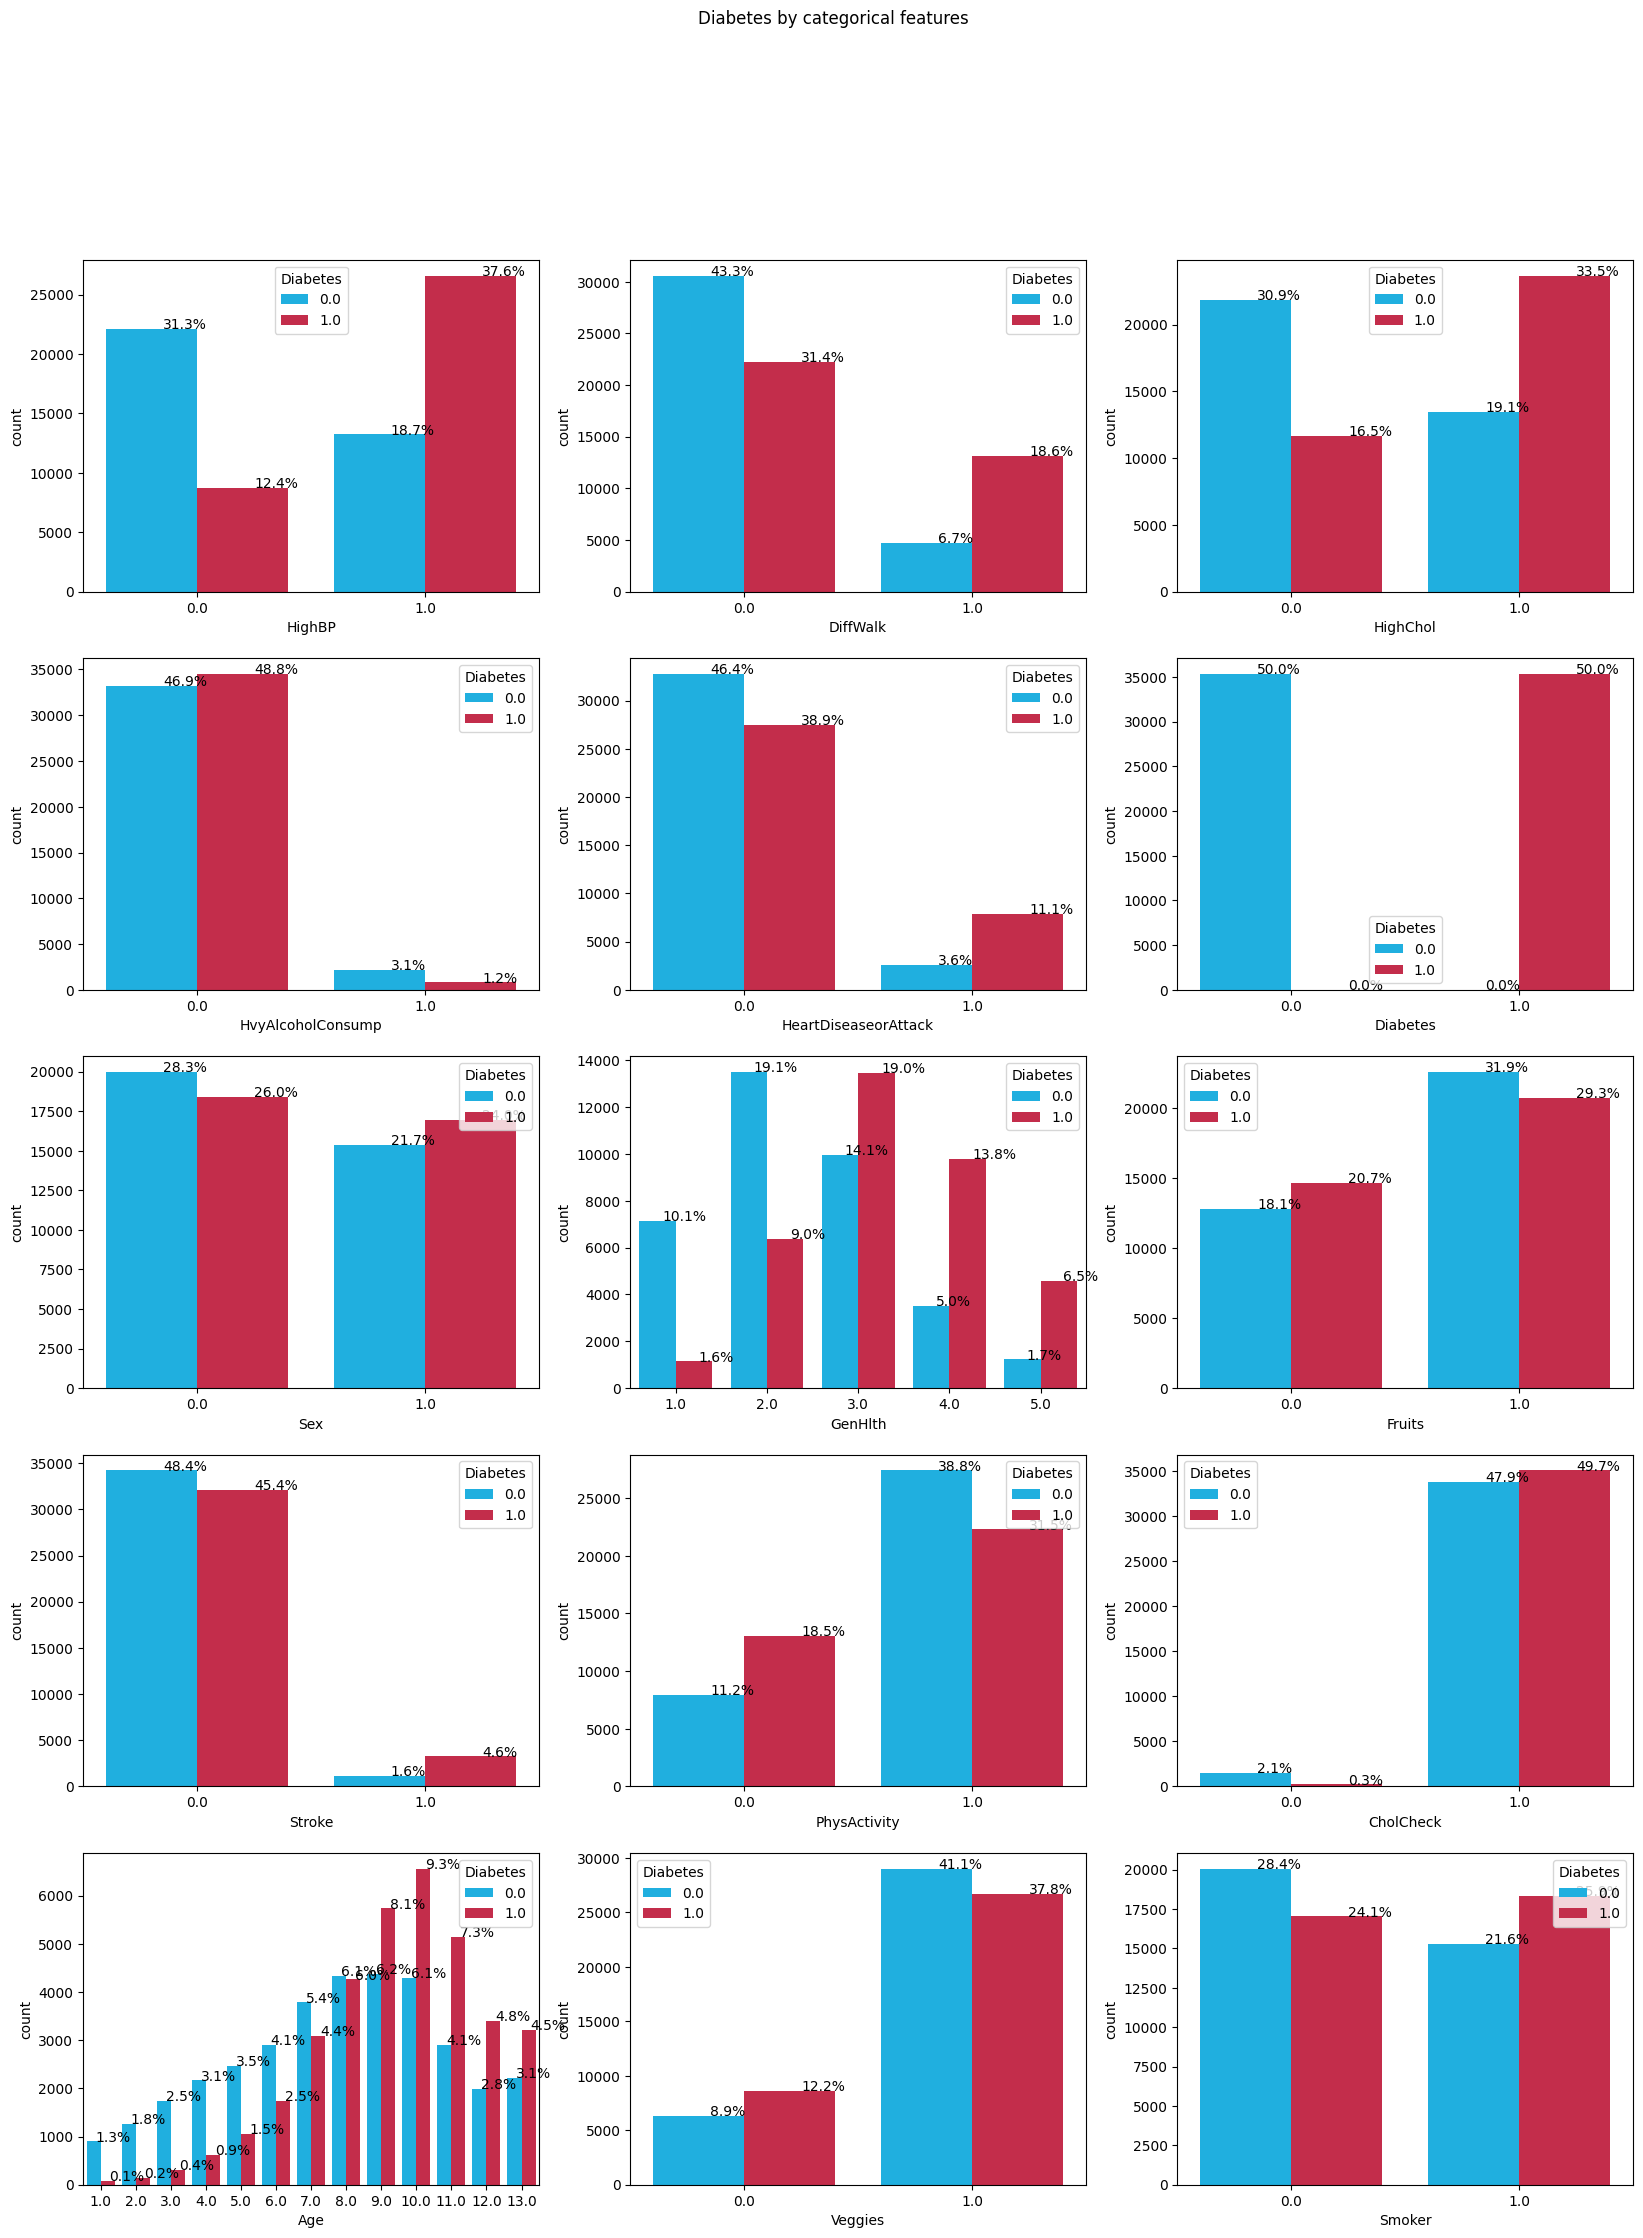

In [53]:
bivariate_bar_plot_for_d(3, categorical_d.copy(), (20,25))

In [54]:
def bivariate_bar_plot_for_s(n_cols, columns, figsize=(12,8)):
    n_rows = int(np.ceil(len(columns) / n_cols))
    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = figsize)
    plt.suptitle('Stroke by categorical features')

    for i, col in enumerate(columns):
        x = sns.countplot(data=data_dict['S'][categorical_s], x=col, hue='stroke', palette = ['deepskyblue','crimson'], ax=ax[i//n_cols, i%n_cols])
        for z in x.patches:
          x.annotate('{:.1f}'.format((z.get_height()/data_dict['S'][categorical_s].shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

In [55]:
n_cols = 3
n_rows = n_rows = int(np.ceil(len(categorical_s.copy()) / n_cols))

"""Histogram using plotly"""
fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=tuple(categorical_s.copy()))

for i, col in enumerate(categorical_s.copy()):
    counts = data_dict['S'][col].value_counts()
    fig.add_trace(go.Bar(name=col, x=counts.index, y=counts.values), 
                  row=i//n_cols + 1,
                  col=i%n_cols + 1)

fig.update_layout(title="Histogram plot of categorical columns",
                 height=800,
                 width=1000,
                 showlegend=False)

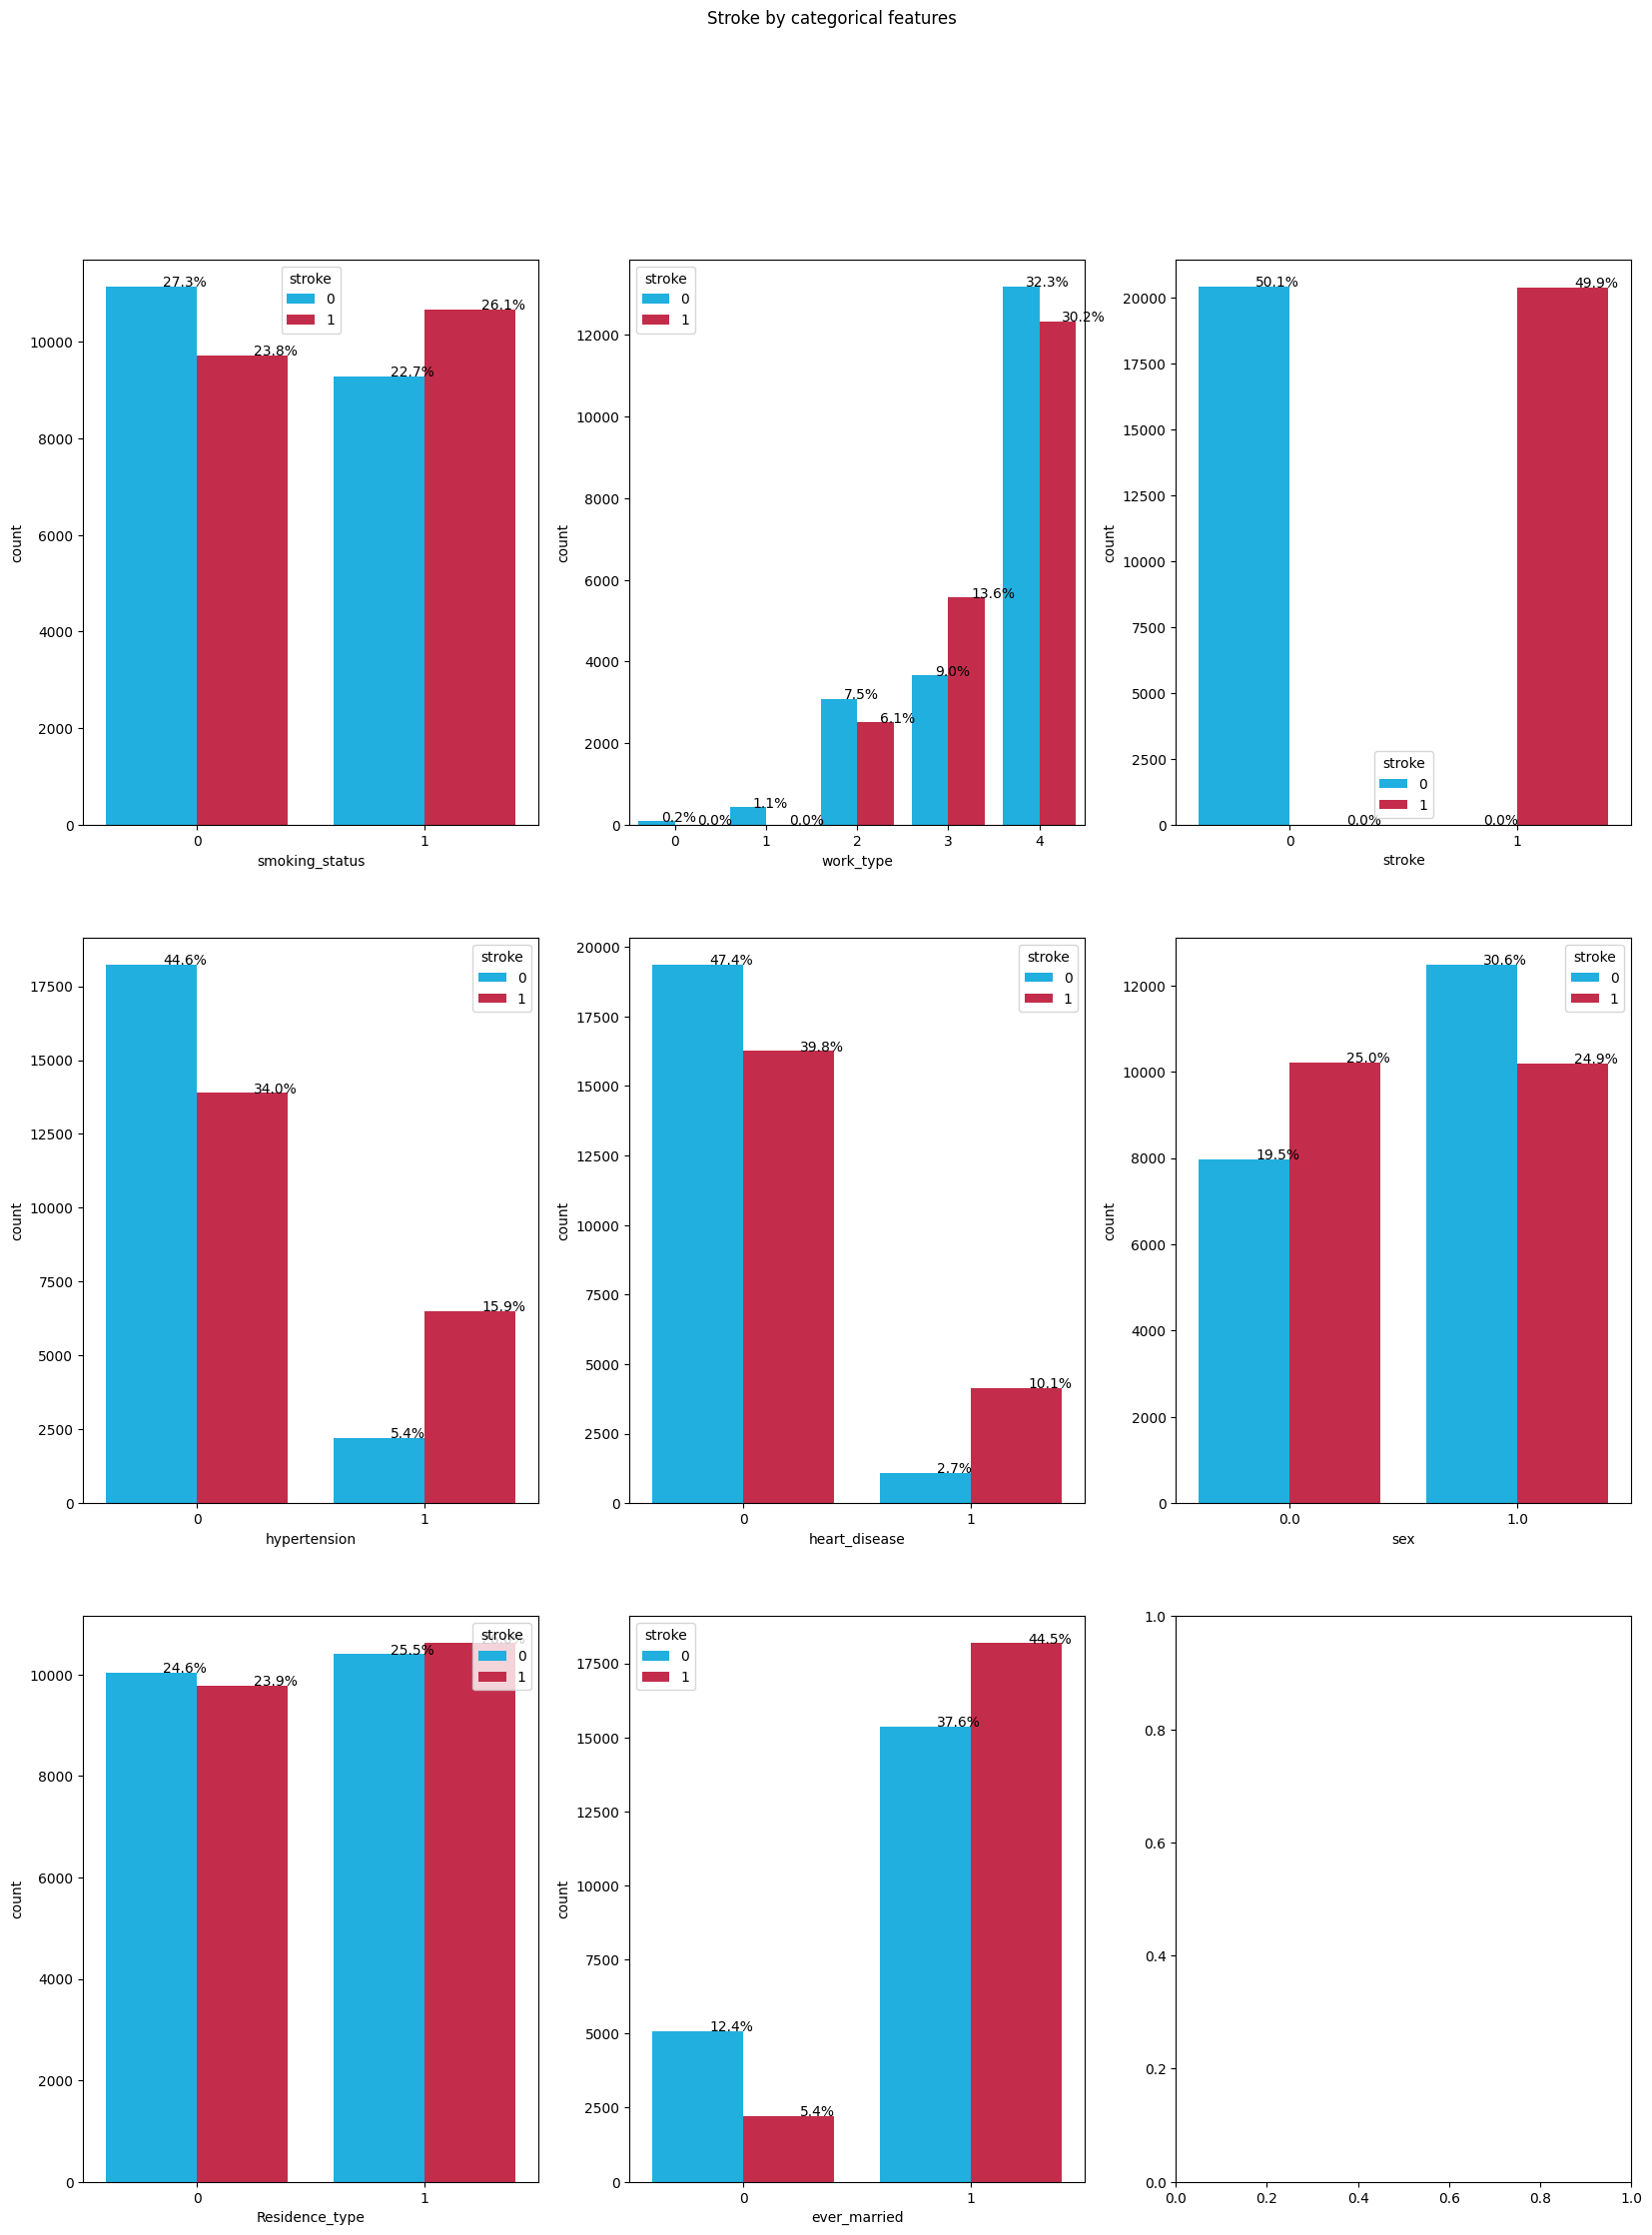

In [56]:
bivariate_bar_plot_for_s(3, categorical_s.copy(), (20,25))

## Convert the categorical variable to numerical
##### Only do for Asthma dataset as other dataset already converted to numerical

In [57]:
for col in data_dict['A'].select_dtypes(include=['object', 'bool']).columns:
    unique_value = np.unique(data_dict['A'][col])
    data_dict['A'][col] = data_dict['A'][col].replace(unique_value, np.arange(len(unique_value)))
    print(f"{col:<16}: {unique_value} have been converted to {np.arange(len(unique_value))}")

SEX             : ['F' 'M'] have been converted to [0 1]
SLEEPING_PROB   : [False  True] have been converted to [0 1]
CHEST_TIGHTNESS : [False  True] have been converted to [0 1]
BREATH          : [False  True] have been converted to [0 1]
COUGH           : [False  True] have been converted to [0 1]
ALLERGY         : [False  True] have been converted to [0 1]
WHEEZING        : [False  True] have been converted to [0 1]
ASTHMA          : [False  True] have been converted to [0 1]


In [58]:
#Check the data type again to make sure it has change to numerical
data_dict['A'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 235396 entries, 0 to 309225
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AGE_YRS          235396 non-null  float64
 1   SEX              235396 non-null  int32  
 2   SLEEPING_PROB    235396 non-null  int32  
 3   CHEST_TIGHTNESS  235396 non-null  int32  
 4   BREATH           235396 non-null  int32  
 5   COUGH            235396 non-null  int32  
 6   ALLERGY          235396 non-null  int32  
 7   WHEEZING         235396 non-null  int32  
 8   ASTHMA           235396 non-null  int32  
dtypes: float64(1), int32(8)
memory usage: 18.8 MB


# Correlation Matrix

<Axes: >

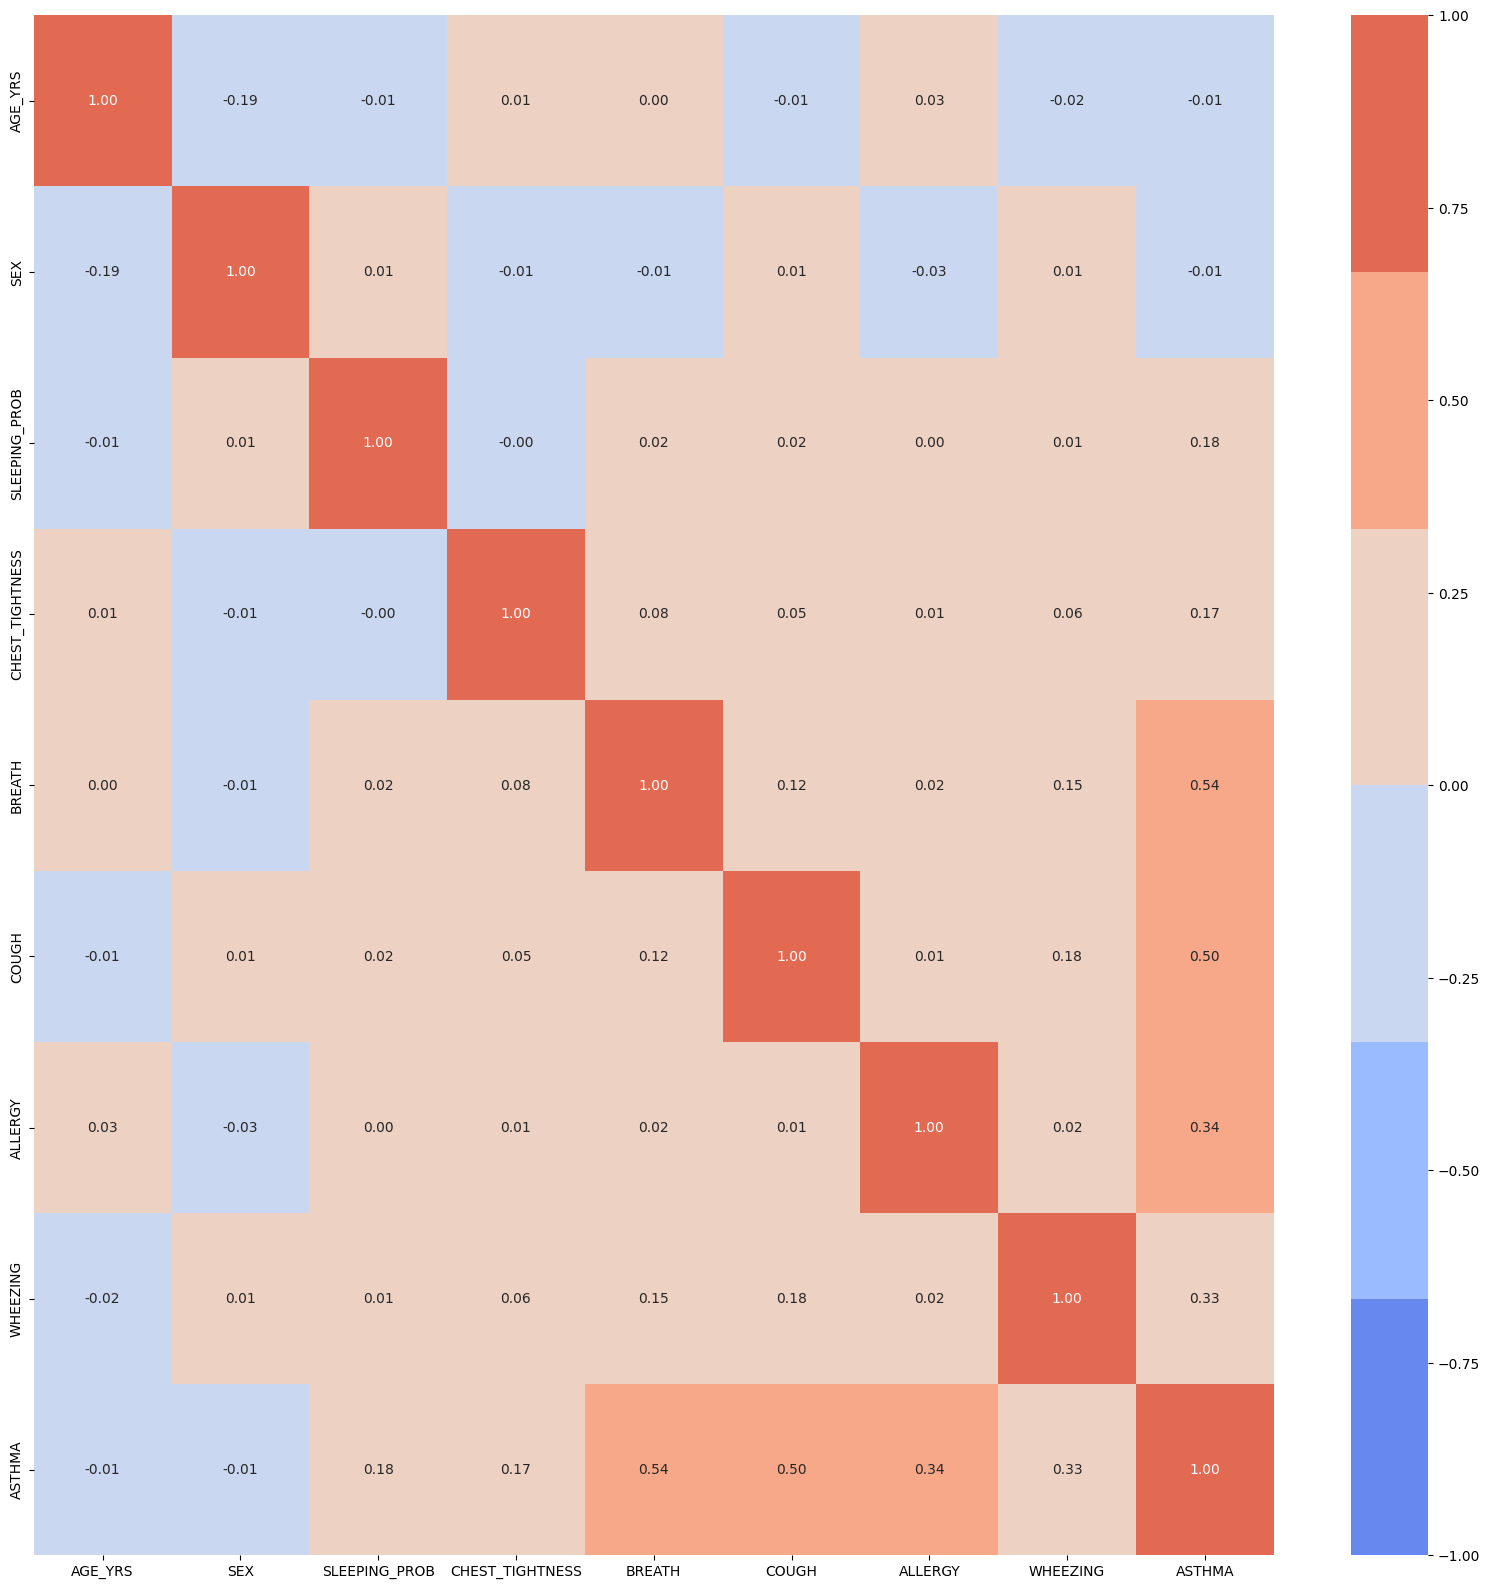

In [59]:
# Overall covariance matrix for Asthma
fig, ax = plt.subplots(figsize=(20, 20))   
sns.heatmap(data_dict['A'].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f", cmap = sns.color_palette("coolwarm"), ax=ax)

<Axes: >

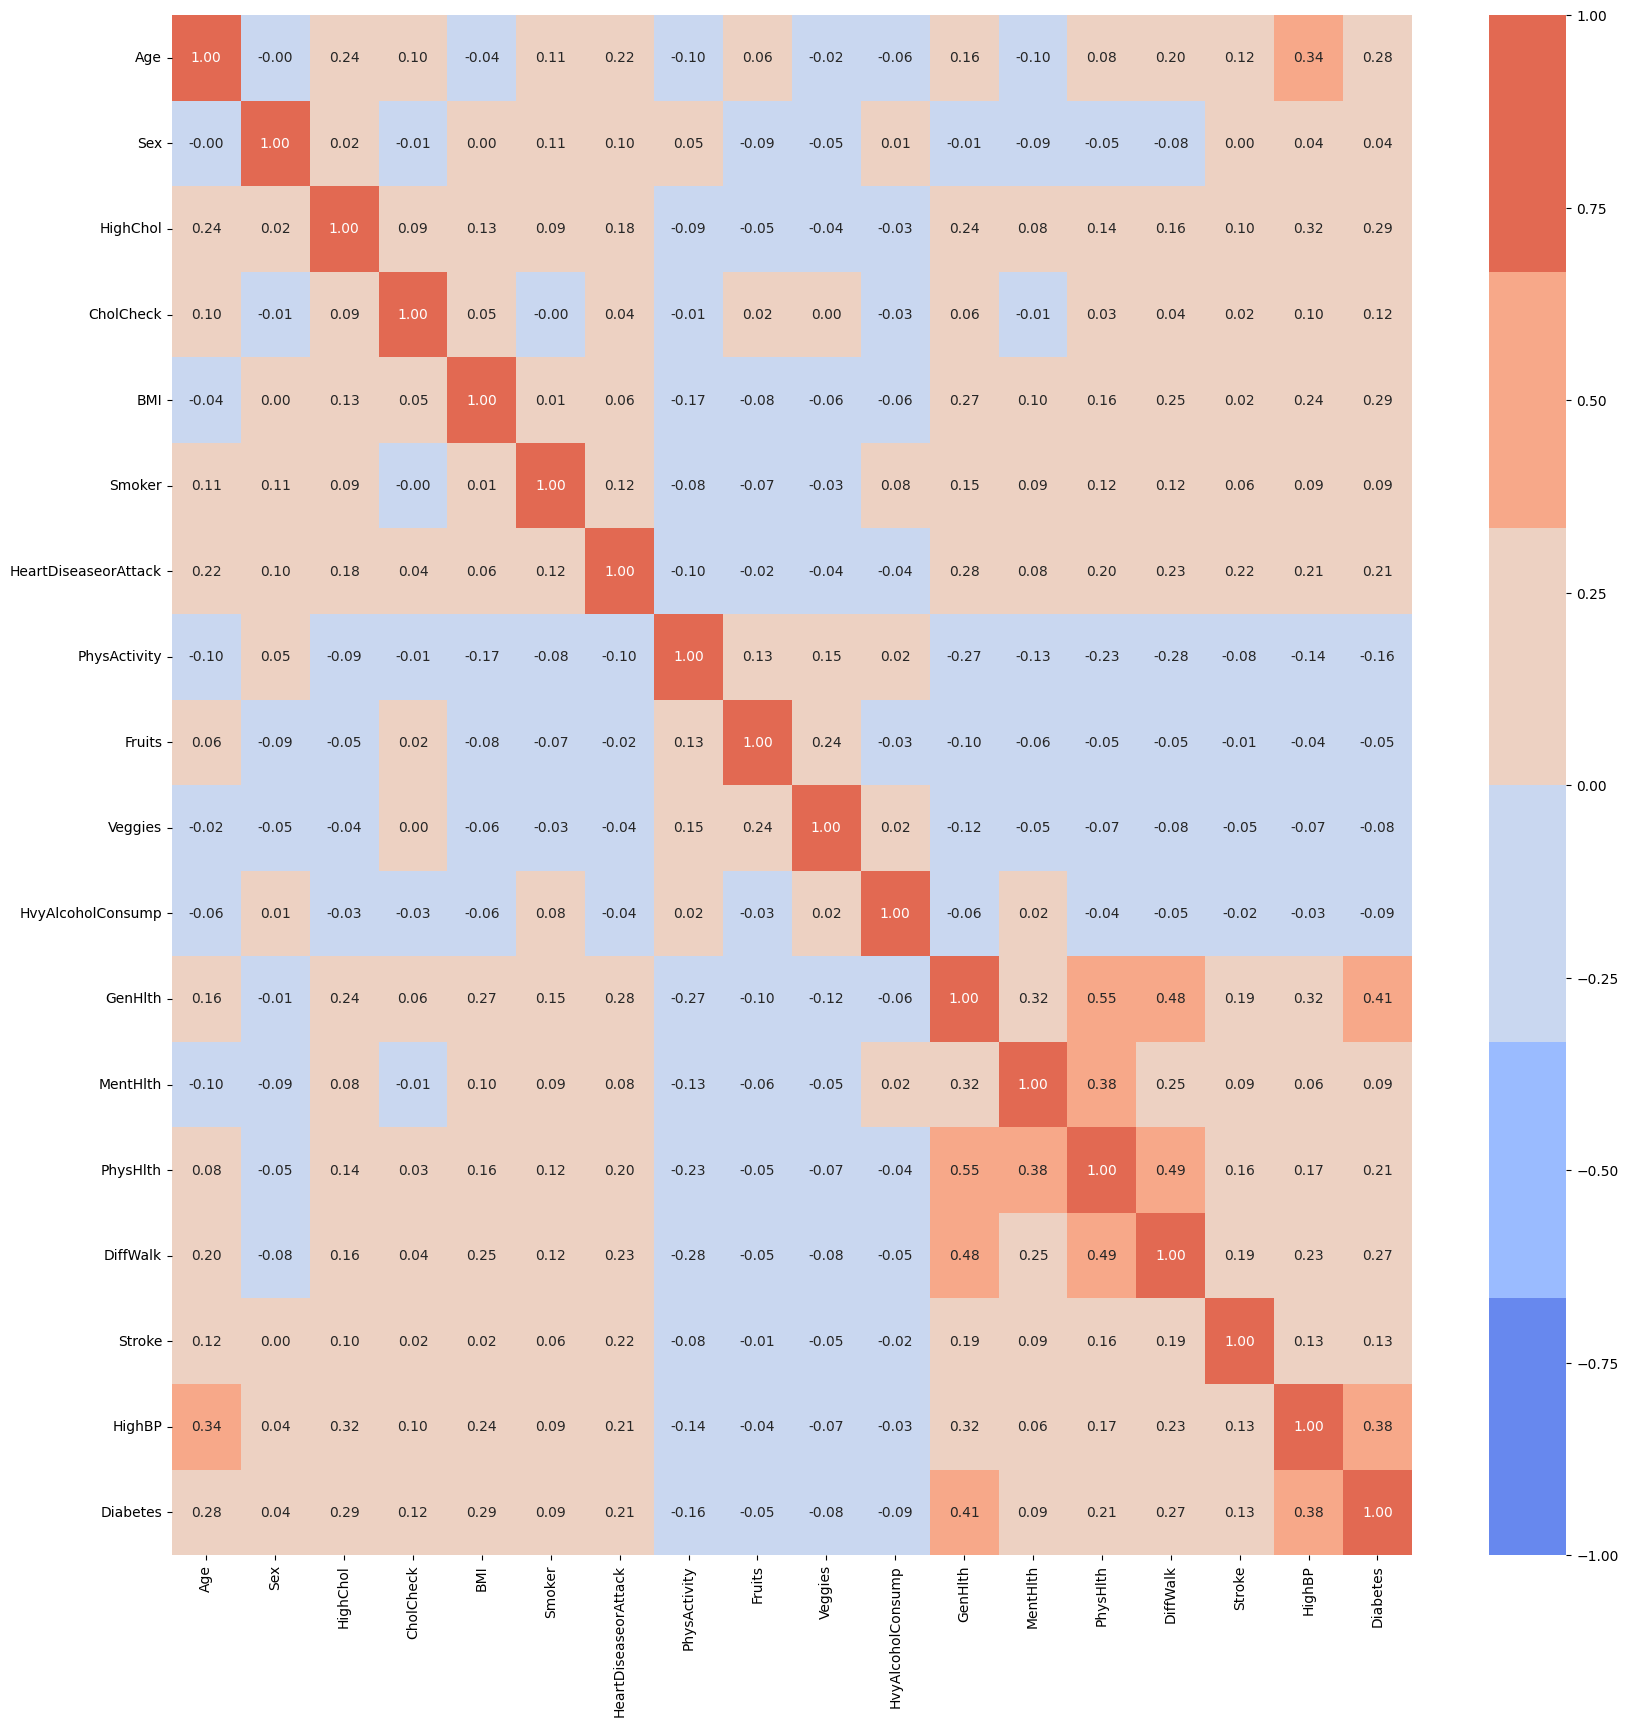

In [60]:
# Overall covariance matrix for Diabetes
fig, ax = plt.subplots(figsize=(20, 20))   
sns.heatmap(data_dict['D'].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f", cmap = sns.color_palette("coolwarm"), ax=ax)

<Axes: >

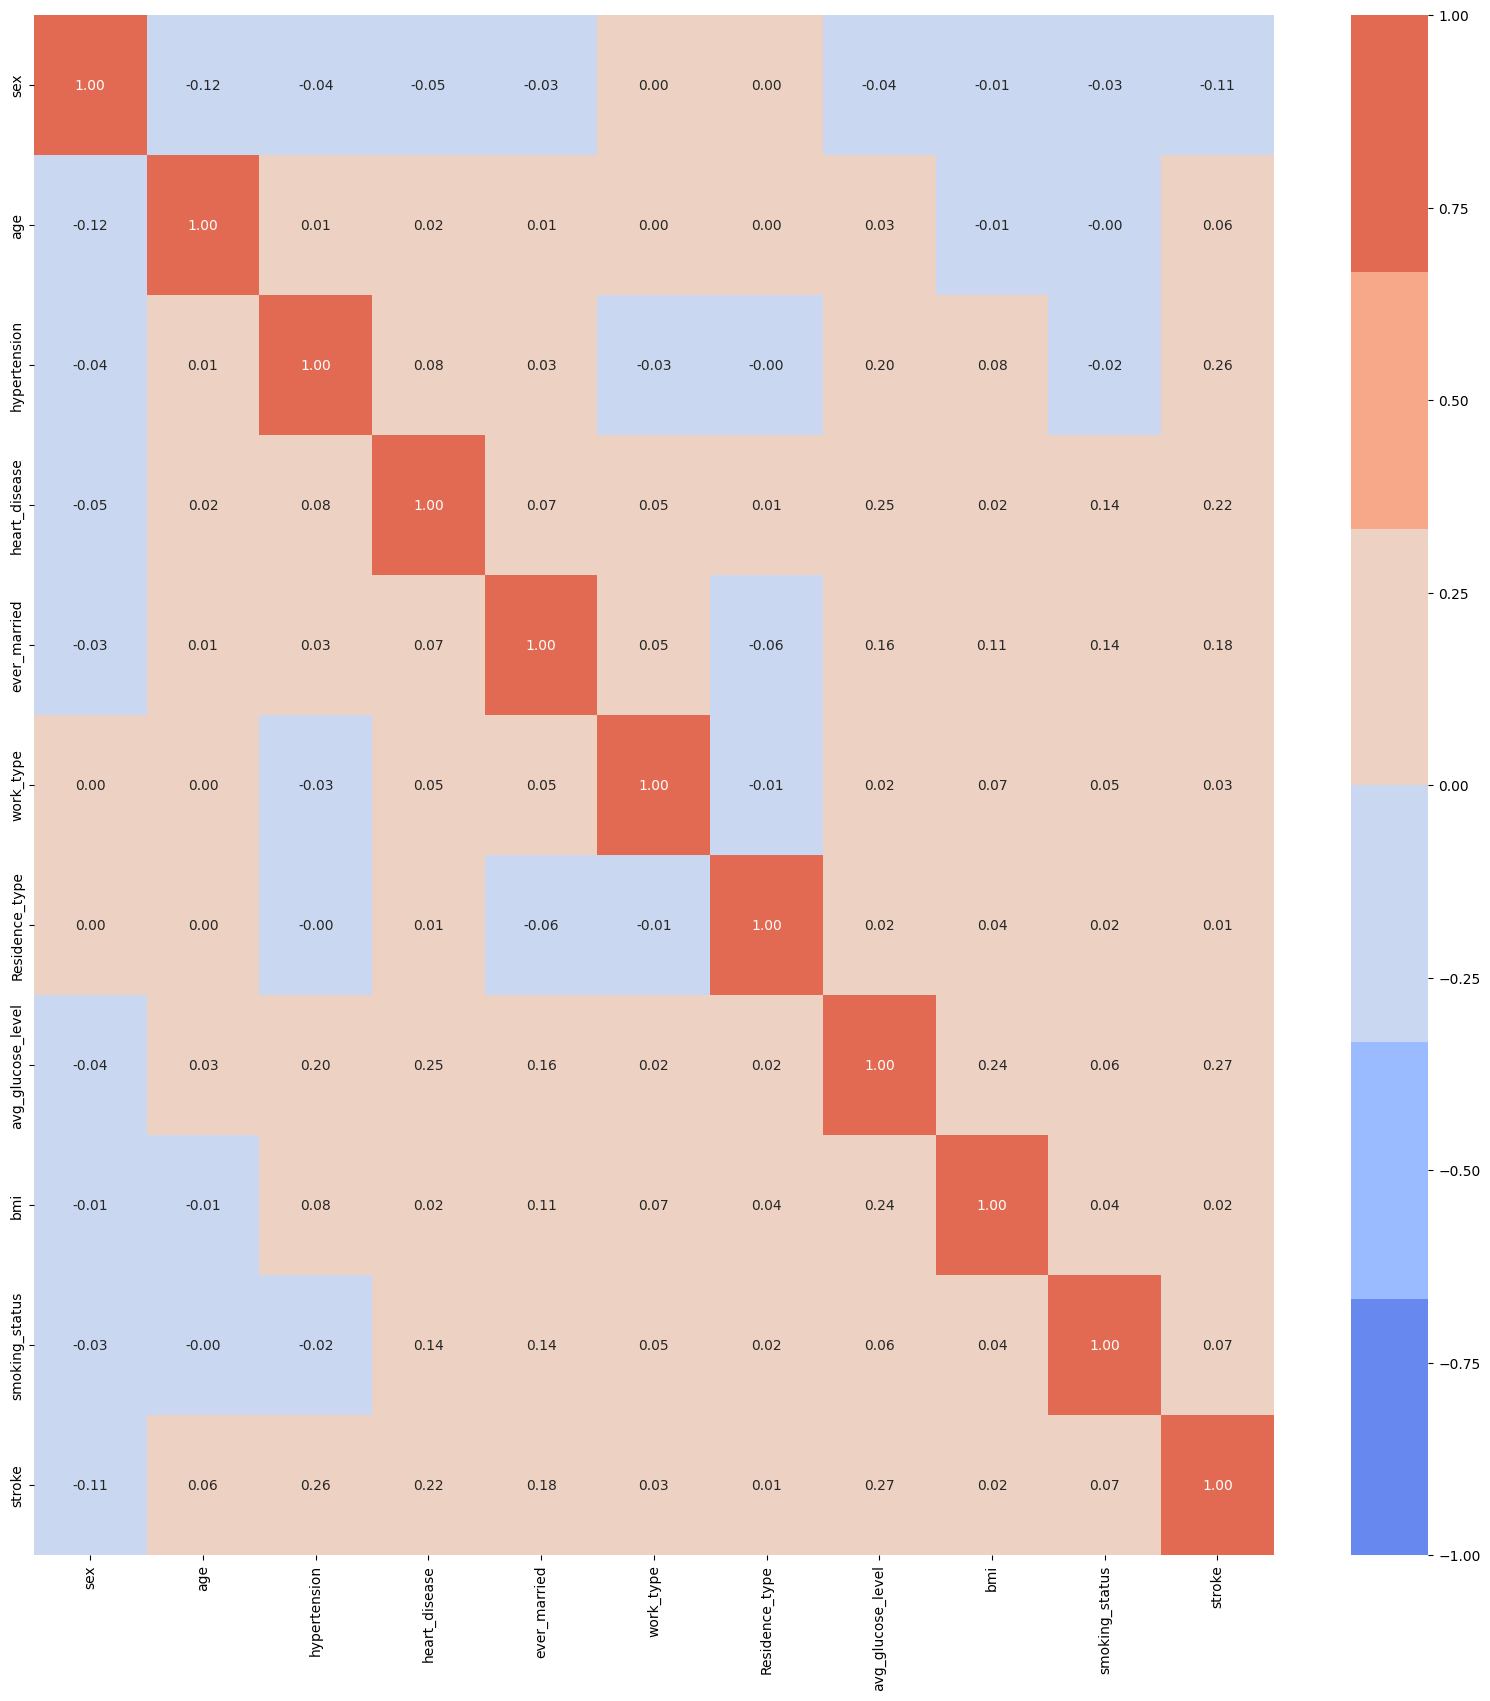

In [50]:
# Overall covariance matrix for Stroke
fig, ax = plt.subplots(figsize=(20, 20))   
sns.heatmap(data_dict['S'].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f", cmap = sns.color_palette("coolwarm"), ax=ax)

In [61]:
# The correlation of each variable with the target variable (Asthma)
fig = go.Figure()
corr_target = data_dict['A'].corr()["ASTHMA"]
fig.add_trace(go.Bar(x=corr_target.index, y=corr_target.values))
fig.update_layout(title="Correlation Histogram between features and target", 
                  xaxis_title='Features', yaxis_title='Correlation', barmode='group')
fig.show()

In [62]:
# The correlation of each variable with the target variable (Diabetes)
fig = go.Figure()
corr_target = data_dict['D'].corr()["Diabetes"]
fig.add_trace(go.Bar(x=corr_target.index, y=corr_target.values))
fig.update_layout(title="Correlation Histogram between features and target", 
                  xaxis_title='Features', yaxis_title='Correlation', barmode='group')
fig.show()

In [63]:
# The correlation of each variable with the target variable (Stroke)
fig = go.Figure()
corr_target = data_dict['S'].corr()["stroke"]
fig.add_trace(go.Bar(x=corr_target.index, y=corr_target.values))
fig.update_layout(title="Correlation Histogram between features and target", 
                  xaxis_title='Features', yaxis_title='Correlation', barmode='group')
fig.show()

# Dataset Normalization

In [64]:
# Normalize for Asthma Dataset
sc = MinMaxScaler()
columns_name = data_dict['A'].columns
data_dict['A'] = sc.fit_transform(data_dict['A'])
data_dict['A'] = pd.DataFrame(data_dict['A'], columns = columns_name)
data_dict['A']

,AGE_YRS,SEX,SLEEPING_PROB,CHEST_TIGHTNESS,BREATH,COUGH,ALLERGY,WHEEZING,ASTHMA
0,0.013393,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.250000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2,0.473214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.616071,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.214286,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
235391,0.276786,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235392,0.785714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235393,0.116071,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
235394,0.071429,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# Normalize for Diabetes Dataset
sc = MinMaxScaler()
columns_name = data_dict['D'].columns
data_dict['D'] = sc.fit_transform(data_dict['D'])
data_dict['D'] = pd.DataFrame(data_dict['D'], columns = columns_name)
data_dict['D']

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,0.250000,1.0,0.0,1.0,0.162791,0.0,0.0,1.0,0.0,1.0,0.0,0.50,0.166667,1.000000,0.0,0.0,1.0,0.0
1,0.916667,1.0,1.0,1.0,0.162791,1.0,0.0,0.0,1.0,0.0,0.0,0.50,0.000000,0.000000,0.0,1.0,1.0,0.0
2,1.000000,1.0,0.0,1.0,0.162791,0.0,0.0,1.0,1.0,1.0,0.0,0.00,0.000000,0.333333,0.0,0.0,0.0,0.0
3,0.833333,1.0,1.0,1.0,0.186047,1.0,0.0,1.0,1.0,1.0,0.0,0.50,0.000000,0.100000,0.0,0.0,1.0,0.0
4,0.583333,0.0,0.0,1.0,0.197674,1.0,0.0,1.0,1.0,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,0.416667,0.0,1.0,1.0,0.290698,0.0,0.0,0.0,0.0,1.0,0.0,0.75,0.000000,0.000000,0.0,0.0,0.0,1.0
70688,0.750000,1.0,1.0,1.0,0.197674,1.0,1.0,0.0,1.0,1.0,0.0,0.25,0.000000,0.000000,1.0,0.0,0.0,1.0
70689,1.000000,0.0,1.0,1.0,0.151163,0.0,1.0,0.0,1.0,0.0,0.0,1.00,0.500000,0.000000,1.0,0.0,1.0,1.0
70690,0.833333,0.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.000000,0.000000,1.0,0.0,1.0,1.0


In [66]:
# Normalize for Stroke Dataset
sc = MinMaxScaler()
columns_name = data_dict['S'].columns
data_dict['S'] = sc.fit_transform(data_dict['S'])
data_dict['S'] = pd.DataFrame(data_dict['S'], columns = columns_name)
data_dict['S']

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,0.611650,0.0,1.0,1.0,1.00,1.0,0.801265,0.311801,1.0,1.0
1,1.0,0.407767,0.0,1.0,1.0,1.00,0.0,0.234512,0.260870,0.0,1.0
2,0.0,0.592233,0.0,0.0,1.0,1.00,1.0,0.536008,0.284472,1.0,1.0
3,1.0,0.398058,1.0,0.0,1.0,0.75,0.0,0.549349,0.155280,0.0,1.0
4,1.0,0.825243,0.0,0.0,1.0,1.00,1.0,0.605161,0.217391,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
40844,1.0,0.368932,0.0,0.0,0.0,1.00,1.0,0.303850,0.226087,1.0,0.0
40845,0.0,0.514563,0.0,0.0,1.0,1.00,0.0,0.104053,0.363975,0.0,0.0
40846,1.0,0.310680,0.0,0.0,1.0,0.50,0.0,0.816314,0.269565,0.0,0.0
40847,1.0,0.407767,0.0,0.0,1.0,0.75,0.0,0.744437,0.285714,0.0,0.0


# Feature Selection

In [67]:
X_d = data_dict['D'].iloc[:, :-1]
y_d = data_dict['D'].iloc[:, -1]

[0.00906781 0.01209799 0.01225217 0.01395    0.01403107 0.01791338
 0.01841334 0.01891588 0.01961157 0.02289631 0.02619249 0.03326236
 0.05434361 0.09561528 0.1196315  0.18003153 0.33177371]
Index(['Stroke', 'PhysActivity', 'Veggies', 'Smoker', 'Fruits', 'Sex',
       'CholCheck', 'HvyAlcoholConsump', 'HeartDiseaseorAttack', 'DiffWalk',
       'MentHlth', 'PhysHlth', 'HighChol', 'Age', 'BMI', 'GenHlth', 'HighBP'],
      dtype='object')


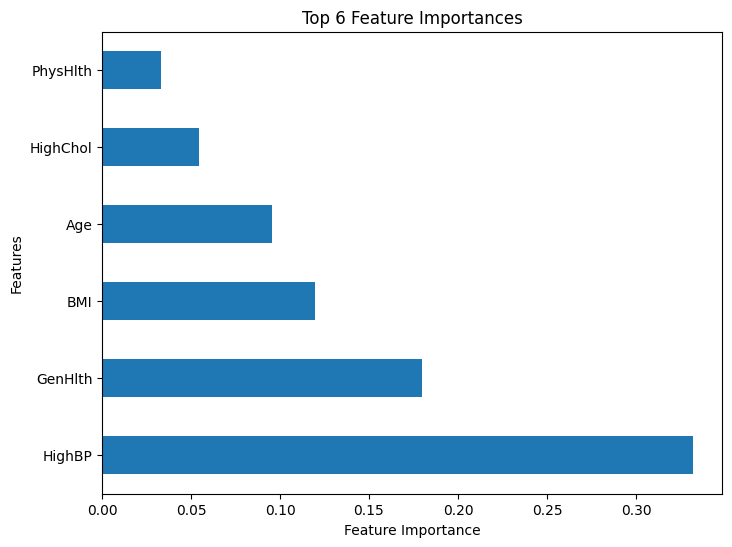

In [69]:
xgb_clf = xgb.XGBClassifier()
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf.fit(X_d, y_d)
rf_clf.fit(X_d, y_d)
gb_clf.fit(X_d, y_d)

average_FI = (xgb_clf.feature_importances_ + rf_clf.feature_importances_  + gb_clf.feature_importances_ )/3
print(np.sort(average_FI))
print(X_d.columns[average_FI.argsort()])
plt.figure(figsize=(8,6))
feat_importances = pd.Series(average_FI, index=X_d.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 6 Feature Importances')
plt.show()

In [ ]:
cols_drop = X_d.columns[average_FI.argsort()][:11].tolist()
# cols_drop.remove('PhysActivity')
print(cols_drop)
X_d = X_d.drop(columns=cols_drop)
X_d.head()

In [ ]:
numerical_cols = [col for col in X_d.columns if len(X_d[col].unique()) > 10]
categorical_cols = list(set(X_d.columns) - set(numerical_cols))
print(numerical_cols)
print(categorical_cols)

In [ ]:
check_skewness(X_d, numerical_cols)

## Quantile Transformation to remove extreme outliers

In [ ]:
X_qt_d = X_d.copy()
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
# numerical_cols.remove('Age')
X_d[['BMI']] = qt.fit_transform(X_d[['BMI']]) 
X_d[['PhysHlth']] = qt.fit_transform(X_d[['PhysHlth']])

In [ ]:
check_skewness(X_d, numerical_cols)

In [54]:
# qt = QuantileTransformer(n_quantiles=150, output_distribution='normal')
# df_qt_d = data_dict['D'].copy()
# df_qt_d[["BMI", "MentHlth", "PhysHlth"]] = qt.fit_transform(data_dict['D'][["BMI", "MentHlth", "PhysHlth"]])

In [55]:
# """KDE distribution of numerical features"""
# fig, ax = plt.subplots(3,2,figsize=(10,15))
# for i,feature in enumerate(["BMI", "MentHlth", "PhysHlth"]):
#     sns.kdeplot(data = data_dict['D']   , x = feature, hue='Diabetes',color = 'deepskyblue', ax=ax[i][0])
#     sns.kdeplot(data = df_qt_d, x = feature, hue='Diabetes',color = 'deepskyblue', ax=ax[i][1])
#     ax[i][0].set_title(f"{feature} - Before")
#     ax[i][1].set_title(f"{feature} - After")

In [56]:
# df_skew = pd.DataFrame(df_qt_d[numerical_d].skew())
# df_skew.columns = ['skewness']

# # |skew| > 0.75 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
# df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.75 
# df_skew

In [57]:
# qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
# df_qt_s = data_dict['S'].copy()
# df_qt_s[["bmi", "avg_glucose_level"]] = qt.fit_transform(data_dict['S'][["bmi", "avg_glucose_level"]])

In [58]:
# """KDE distribution of numerical features"""
# fig, ax = plt.subplots(2,2,figsize=(10,10))
# for i,feature in enumerate(["bmi", "avg_glucose_level"]):
#     sns.kdeplot(data = data_dict['S']   , x = feature, hue='stroke',color = 'deepskyblue', ax=ax[i][0])
#     sns.kdeplot(data = df_qt_s, x = feature, hue='stroke',color = 'deepskyblue', ax=ax[i][1])
#     ax[i][0].set_title(f"{feature} - Before")
#     ax[i][1].set_title(f"{feature} - After")

In [59]:
# df_skew = pd.DataFrame(df_qt_s[numerical_s].skew())
# df_skew.columns = ['skewness']

# # |skew| > 0.75 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
# df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.75 
# df_skew

In [60]:
# data_dict['S'] = df_qt_s.copy()
# del df_qt_s

# Data spliting for training and testing

In [64]:
data = data_dict['A'].iloc[:,data_dict['A'].columns != "ASTHMA"]
label = data_dict['A']["ASTHMA"]
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(data, label, test_size=0.3, random_state=42)
print(f"After spliting X_train shape: {X_train_a.shape} y_train shape: {y_train_a.shape}")
print(f"After spliting X_test  shape: {X_test_a.shape} y_test  shape: {y_test_a.shape}")

After spliting X_train shape: (164777, 8) y_train shape: (164777,)
After spliting X_test  shape: (70619, 8) y_test  shape: (70619,)


In [65]:
data = data_dict['D'].iloc[:,data_dict['D'].columns != "Diabetes"]
label = data_dict['D']["Diabetes"]
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(data, label, test_size=0.3, random_state=42)
print(f"After spliting X_train shape: {X_train_d.shape} y_train shape: {y_train_d.shape}")
print(f"After spliting X_test  shape: {X_test_d.shape} y_test  shape: {y_test_d.shape}")

After spliting X_train shape: (49484, 17) y_train shape: (49484,)
After spliting X_test  shape: (21208, 17) y_test  shape: (21208,)


In [66]:
data = data_dict['S'].iloc[:,data_dict['S'].columns != "stroke"]
label = data_dict['S']["stroke"]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(data, label, test_size=0.3, random_state=42)
print(f"After spliting X_train shape: {X_train_s.shape} y_train shape: {y_train_s.shape}")
print(f"After spliting X_test  shape: {X_test_s.shape} y_test  shape: {y_test_s.shape}")

After spliting X_train shape: (28634, 10) y_train shape: (28634,)
After spliting X_test  shape: (12273, 10) y_test  shape: (12273,)


[0.15355317 0.03120948 0.04174753 0.00664228 0.213215   0.03344061
 0.02137542 0.02759039 0.0330522  0.02692774 0.01096163 0.11466859
 0.06794149 0.08880869 0.02825331 0.01169849 0.088914  ]


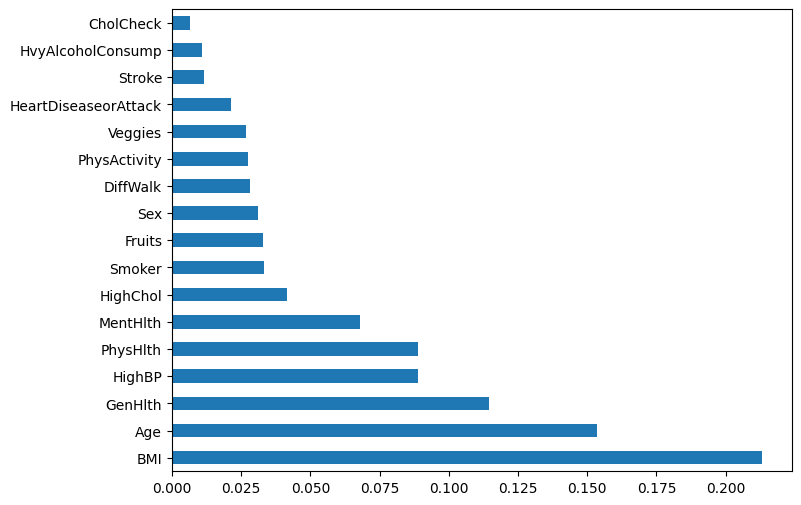

In [67]:
model = RandomForestClassifier()
model.fit(X_train_d, y_train_d)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_d.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

In [ ]:
y_test_out = model.predict(X_test_d)
print(f"For Random Forest:")
print("The accuracy  on the test data:",accuracy_score(y_test_d,y_test_out))

[0.03460073 0.01763153 0.05570144 0.04255543 0.02648637 0.01110192
 0.02619472 0.01064505 0.00997483 0.01221816 0.0305062  0.12677105
 0.00998861 0.0102658  0.02722642 0.0140343  0.53409743]


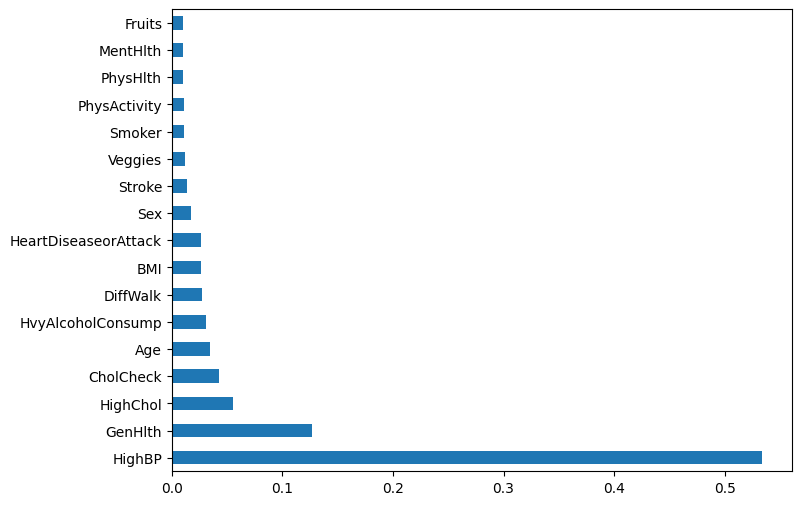

In [68]:
model = xgb.XGBClassifier()
model.fit(X_train_d, y_train_d)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_d.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

In [69]:
y_test_out = model.predict(X_test_d)
print(f"For XGB:")
print("The accuracy  on the test data:",accuracy_score(y_test_d,y_test_out))

For XGB:
The accuracy  on the test data: 0.7513674085250849


In [70]:
X_train_d = X_train_d.drop(columns=['Fruits','MentHlth','PhysHlth','PhysActivity','Smoker','Veggies','Stroke','Sex'])

[0.036624   0.06342582 0.04495011 0.02764918 0.02820969 0.03505386
 0.13429882 0.0231619  0.6066266 ]


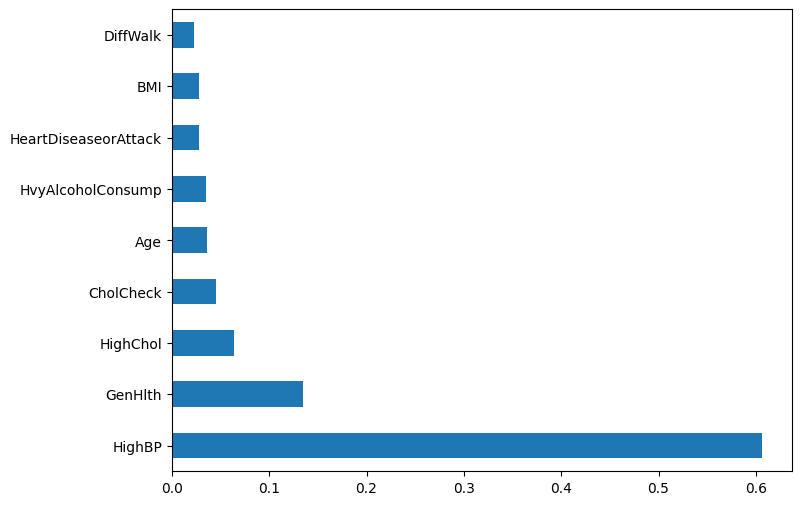

In [73]:
model = xgb.XGBClassifier()
model.fit(X_train_d, y_train_d)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_d.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

In [74]:
y_test_out = model.predict(X_test_d.drop(columns=['Fruits','MentHlth','PhysHlth','PhysActivity','Smoker','Veggies','Stroke','Sex']))
print(f"For XGB:")
print("The accuracy  on the test data:",accuracy_score(y_test_d,y_test_out))

For XGB:
The accuracy  on the test data: 0.748491135420596


## Recursive Feature Elimination

In [ ]:
# #Asthma
# def RFE_using_model_for_a(model, model_name):
#     rfe   = RFE(model, n_features_to_select=1)
#     fit   = rfe.fit(X_train_a, y_train_a)
    
#     # Try to use the fit the model to obtain the accuracy on the test dataset
#     model.fit(X_train_a, y_train_a)
#     y_test_out = model.predict(X_test_a)
#     print(f"For {model_name}:")
#     print("The accuracy  on the test data:",accuracy_score(y_test_a,y_test_out))
#     print("The precision on the test data:",precision_score(y_test_a,y_test_out, average="weighted"))
#     print("The recall    on the test data:",recall_score(y_test_a,y_test_out, average="weighted"), "\n")
    

In [ ]:
# #Diabetes
# def RFE_using_model_for_d(model, model_name):
#     rfe   = RFE(model, n_features_to_select=1)
#     fit   = rfe.fit(X_train_d, y_train_d)
    
#     # Try to use the fit the model to obtain the accuracy on the test dataset
#     model.fit(X_train_d, y_train_d)
#     y_test_out = model.predict(X_test_d)
#     print(f"For {model_name}:")
#     print("The accuracy  on the test data:",accuracy_score(y_test_d,y_test_out))
#     print("The precision on the test data:",precision_score(y_test_d,y_test_out, average="weighted"))
#     print("The recall    on the test data:",recall_score(y_test_d,y_test_out, average="weighted"), "\n")
    

In [ ]:
# #Stroke
# def RFE_using_model_for_s(model, model_name):
#     rfe   = RFE(model, n_features_to_select=1)
#     fit   = rfe.fit(X_train_s, y_train_s)
    
#     # Try to use the fit the model to obtain the accuracy on the test dataset
#     model.fit(X_train_s, y_train_s)
#     y_test_out = model.predict(X_test_s)
#     print(f"For {model_name}:")
#     print("The accuracy  on the test data:",accuracy_score(y_test_s,y_test_out))
#     print("The precision on the test data:",precision_score(y_test_s,y_test_out, average="weighted"))
#     print("The recall    on the test data:",recall_score(y_test_s,y_test_out, average="weighted"), "\n")
    

### Random Forest in Feature Selection

In [ ]:
# %%time
# RFE_using_model_for_a(RandomForestClassifier(n_estimators=30, n_jobs=-1), "Asthma Random Forest")
# RFE_using_model_for_d(RandomForestClassifier(n_estimators=30, n_jobs=-1), "Diabetes Random Forest")
# RFE_using_model_for_s(RandomForestClassifier(n_estimators=30, n_jobs=-1), "Stroke Random Forest")

### Gradient Boosting in Feature Selection

In [ ]:
# %%time
# RFE_using_model_for_a(GradientBoostingClassifier(), "Asthma Random Forest")
# RFE_using_model_for_d(GradientBoostingClassifier(), "Diabetes Random Forest")
# RFE_using_model_for_s(GradientBoostingClassifier(), "Stroke Random Forest")

# Model Building

## Asthma Prediction Model

### XGBoost Model

In [ ]:
XGB = xgb.XGBClassifier()
XGB.fit(X_train_a, y_train_a)

print(XGB)

In [ ]:
expected_y  = y_test_a
predicted_y = XGB.predict(X_test_a)

In [ ]:
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

### Random Forest Model

In [ ]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

# defining parameter range
param_grid = {'n_estimators':[15, 20, 30, 40, 50, 100, 150, 200, 300, 400]
              }  
gridRF = GridSearchCV(RF, param_grid)
  
# fitting the model for grid search
gridRF.fit(X_train_a, y_train_a)

print(gridRF.best_params_)

In [ ]:
y_pred_test = gridRF.predict(X_test_a)
y_pred_train = gridRF.predict(X_train_a)

In [ ]:
print(accuracy_score(y_train_a, y_pred_train))
print(accuracy_score(y_test_a, y_pred_test))

In [ ]:
#confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_a, y_pred_test, labels=gridRF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gridRF.classes_)
fig = plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues) 
plt.grid(which='major')     #remove cell gridlines
plt.gcf().set_size_inches(6, 6)   # Adjust the size of the plot
plt.show()

### Logistic Regression Model

In [ ]:
LR = LogisticRegression(solver='liblinear', random_state=0)
LR.fit(X_train_a, y_train_a)

In [ ]:
predicted_y = LR.predict(X_test_a)

In [ ]:
print(metrics.classification_report(y_test_a, predicted_y))
print(metrics.confusion_matrix(y_test_a, predicted_y))

## Diabetes Prediction Model

### XGBoost Model

In [ ]:
XGB = xgb.XGBClassifier()
XGB.fit(X_train_s, y_train_s)

print(XGB)

In [ ]:
expected_y  = y_test_s
predicted_y = XGB.predict(X_test_s)

In [ ]:
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

### Random Forest Model

In [ ]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

# defining parameter range
param_grid = {'n_estimators':[15, 20, 30, 40, 50, 100, 150, 200, 300, 400]
              }  
gridRF = GridSearchCV(RF, param_grid)
  
# fitting the model for grid search
gridRF.fit(X_train_s, y_train_s)

print(gridRF.best_params_)

In [ ]:
y_pred_test = gridRF.predict(X_test_s)
y_pred_train = gridRF.predict(X_train_s)

In [ ]:
print(accuracy_score(y_train_s, y_pred_train))
print(accuracy_score(y_test_s, y_pred_test))

In [ ]:
#confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_s, y_pred_test, labels=gridRF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gridRF.classes_)
fig = plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues) 
plt.grid(which='major')     #remove cell gridlines
plt.gcf().set_size_inches(6, 6)   # Adjust the size of the plot
plt.show()

### Logistic Regression Model

In [ ]:
LR = LogisticRegression(solver='liblinear', random_state=0)
LR.fit(X_train_a, y_train_a)

In [ ]:
predicted_y = LR.predict(X_test_a)

In [ ]:
print(metrics.classification_report(y_test_a, predicted_y))
print(metrics.confusion_matrix(y_test_a, predicted_y))

## Stroke Prediction Model

### XGBoost Model

In [ ]:
XGB = xgb.XGBClassifier()
XGB.fit(X_train_s, y_train_s)

print(XGB)

In [ ]:
expected_y  = y_test_s
predicted_y = XGB.predict(X_test_s)

In [ ]:
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

### Random Forest Model

In [ ]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

# defining parameter range
param_grid = {'n_estimators':[15, 20, 30, 40, 50, 100, 150, 200, 300, 400]
              }  
gridRF = GridSearchCV(RF, param_grid)
  
# fitting the model for grid search
gridRF.fit(X_train_s, y_train_s)

print(gridRF.best_params_)

In [ ]:
y_pred_test = gridRF.predict(X_test_s)
y_pred_train = gridRF.predict(X_train_s)

In [ ]:
print(accuracy_score(y_train_s, y_pred_train))
print(accuracy_score(y_test_s, y_pred_test))

In [ ]:
#confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_s, y_pred_test, labels=gridRF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gridRF.classes_)
fig = plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues) 
plt.grid(which='major')     #remove cell gridlines
plt.gcf().set_size_inches(6, 6)   # Adjust the size of the plot
plt.show()

### Logistic Regression Model

In [ ]:
LR = LogisticRegression(solver='liblinear', random_state=0)
LR.fit(X_train_s, y_train_s)

In [ ]:
predicted_y = LR.predict(X_test_s)

In [ ]:
print(metrics.classification_report(y_test_s, predicted_y))
print(metrics.confusion_matrix(y_test_s, predicted_y))

In [ ]:
model = RandomForestClassifier()
model.fit(X_train_a, y_train_a)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_a.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

In [ ]:
model = RandomForestClassifier()
model.fit(X_train_d, y_train_d)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_d.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

In [ ]:
model = RandomForestClassifier()
model.fit(X_s,y_s)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_s.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
model = GradientBoostingClassifier()
model.fit(X_a,y_a)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_a.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

In [ ]:
model = GradientBoostingClassifier()
model.fit(X_d,y_d)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_d.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

In [ ]:
model = GradientBoostingClassifier()
model.fit(X_s,y_s)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_s.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
model = SVC(kernel='linear')
model.fit(X_a,y_a)

# Compute feature importance
feature_importance = abs(model.coef_[0])
feature_names = X_a.columns

# Plot graph of feature importances
feat_importances = pd.Series(feature_importance, index=feature_names)
plt.figure(figsize=(8, 6))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()